In [1]:
import time
import math
import pyaudio
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
import spiUtils as su
import spidev

### pyAudio functions

In [9]:
#class for writing to speaker
class Output:
    pa = None;
    s  = None;
    #call this function to open output and create stream
    def __init__(self,rate=8000):
        """
        Output class constructor initializes and opens pyAudio output
        stream. Allows sending audio data to an audio output device via python.
        """
        #print ("init_audio: Create PyAudio object")
        self.pa = pyaudio.PyAudio()
        #print ("init_audio: Open stream")
        self.s = self.pa.open(output=True,
                channels=1,
                rate=rate,
                format=pyaudio.paInt16,
                output_device_index=0)
        print ("audio stream initialized")

    def close_audio(self):
        """
        Output class destructor closes and destructs output object
        and associated pyAudio stream.
        """
        #print ("close_audio: Closing stream")
        self.s.close()
        print ("close_audio: Terminating PyAudio Object")
        self.pa.terminate()
        
    #create a numpy array of a given freqeuncy    
    def note(self, freq, len, amp=5000, rate=8000, 
            vibrato=0,vibratoFreq=0):
        """
        Creates a uniform note (a sinusoidal waveform of with characteristics specified
        by function parameters) returned as a 16bit integer numpy array.
        """
        t = np.linspace(0,len,len*rate)
        freq_data= (freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))
        data = np.sin(2*np.pi*(freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))*t)*amp
        plt.plot(freq_data)
        #np.savetxt('test.out', freq)
        return data.astype(np.int16) # two byte integers
    
    
    #write numpy array to stream
    def tone(self, note):
        """
        Takes a 16bit integer numpy array, representing a note, as an argument
        and plays the represented note via the pyAudio stream.
        """
        # generate sound
        self.s.write(note)
    
    #add two numpy arrays together
    def add_note(self, note1, note2):
        """
        combines two notes (of the same length) element-wise to produce a new note.
        """
        return note1 + note2
    
    

### signal processing functions

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=1):
    """
    Uses linear interpolation to upsample numpy arrays to a uniform shape
    to accomodate the pyAudio stream parameters.
    """
    SAMP_DURATION = float(SAMP_DURATION) # seconds
    data_len = len(data)
    fs = data_len / SAMP_DURATION
    xp = np.arange(data_len)
    x = np.linspace(0, data_len, 8000*int(SAMP_DURATION))
    upsamp_data = np.interp(x, xp, data) * MAG_SCALAR
    return upsamp_data

### Potentiometer SPI sampling function

In [11]:
# GPIO setup
GPIO.setmode(GPIO.BCM)

ADC2 = 4
GPIO.setup(ADC2, GPIO.OUT)

ADC3 = 5
GPIO.setup(ADC3, GPIO.OUT)



def init_Spi():
    spi1 = spidev.SpiDev()       # Create a new spidev object
    spi1.open(0,0)
    spi1.max_speed_hz = int(20e5) # Set clock speed to 

    spi2 = spidev.SpiDev()       # Create a new spidev object
    spi2.open(0,1)
    spi2.max_speed_hz = int(20e5) # Set clock speed to ___
    
    GPIO.output(ADC2, True)
    GPIO.output(ADC3, True)
    
    return spi1, spi2
def readPiezo():
    config = [0b01101000, 0] # Measure from channel 0
    myBytes = spi1.xfer2(config)             # Send and get array of 2 bytes from ADC
    myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
    return myData

def readPot(input, spi1, spi2):
    
    if(input==0):
        config = [0b01111000, 0] # Measure from channel 1
        myBytes = spi1.xfer2(config)             # Send and get array of 2 bytes from ADC
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData   
     
    if(input==1):
        config = [0b01101000, 0] # Measure from channel 0
        GPIO.output(ADC2, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC2, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==2):
        config = [0b01111000, 0] # Measure from channel 1
        GPIO.output(ADC2, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC2, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==3):
        config = [0b01101000, 0] # Measure from channel 0
        GPIO.output(ADC3, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC3, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==4):
        config = [0b01111000, 0] # Measure from channel 1
        GPIO.output(ADC3, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC3, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData


### tone library

In [11]:
keys = {
    "c4": 261.63,
    "d4": 293.66,
    "e4": 329.63,
    "f4": 349.23,
    "g4": 392,
    "a4": 440,
    "b4": 493.88,
    "c5": 523.25
}

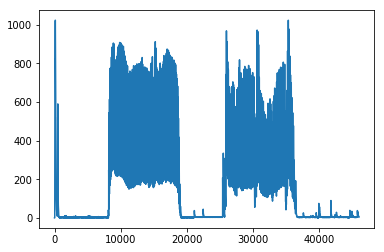

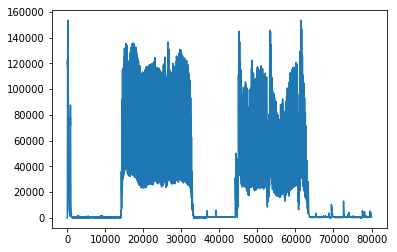

80000
audio stream initialized
start playing tones
Interrupt!
Done!
close_audio: Terminating PyAudio Object


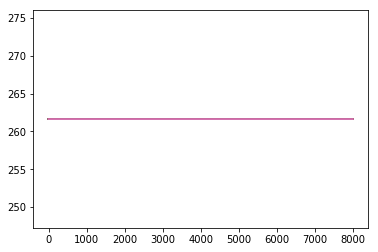

In [7]:


#this is all kinda random stuff
try:
        
    data = np.load("dig22Apr19.npy")

    upsamp_data = interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=150)
    
    plt.plot(data)
    plt.show()
    plt.plot(upsamp_data)
    plt.show()
    
    print(len(upsamp_data))
    #up_samp = 150 * up_samp
    filtered_data = butter_lowpass_filter(upsamp_data, 200,8000, 5)
    aO = Output()
      # play tones forever    
    print( "start playing tones")
    while True:
        
        aO.tone(upsamp_data.astype(np.int16))
        time.sleep(.5)
        aO.tone(aO.note(keys['c4'], 1))
        
        #c1 = aO.note
        #aO.tone(aO.note(keys['d4'], 1))
        #aO.tone(aO.note(keys['e4'], 1))
        #aO.tone(aO.note(keys['f4'], 1))
        #aO.tone(aO.note(keys['g4'], 1))
        #aO.tone(aO.note(keys['a4'], 1))
        #aO.tone(aO.note(keys['b4'], 1))
        #aO.tone(aO.note(keys['c5'], 1))
        #time.sleep(1)
        #aO.tone(aO.note(100, 10, vibrato=10,vibratoFreq=5))
        #aO.tone(aO.note(keys['c4'], 1))
        #aO.tone(aO.note(keys['c4'], 5, vibrato=.5,vibratoFreq=5000))
        
        
except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")

finally:
    print("Done!")
    aO.close_audio();           
         

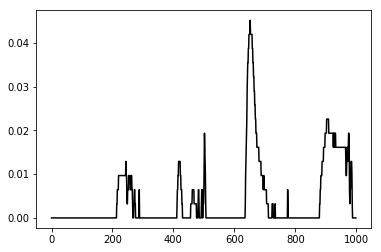

Done!
close_audio: Terminating PyAudio Object


In [17]:


try:
    # This n value takes a few seconds to run so you can test
    nDATA  = 1000
    #toVolt = 3.3/1023
    dPIEZO = np.zeros(nDATA,dtype='float')

        
    plt.plot(dPIEZO,'k');
    plt.show()    
   
    #while True:
    # get a packet of data from the piezo
    for i in range(nDATA):
        #dPIEZO[i] = toVolt * su.readADC(channel=0) # PIEZO element
        dPIEZO[i] = su.readADC(channel=0) # PIEZO element
    
    # if the data has a signature of the resonating digeridoo
    if np.amax(dPiezo) > .02:
        # collect all of the potentiometer values
        
        # generate an output signal
        
        # play the output signal
        
    # otherwise, continue
        
except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")

finally:
    print("Done!")
    aO.close_audio();           

In [ ]:
spi1, spi2 = init_Spi()

while (True):
    print(readPot(1,spi1, spi2))
    

866
867
867
862
856
870
861
863
864
862
858
856
868
867
869
871
866
868
868
860
856
863
868
856
865
854
864
871
865
868
872
863
867
859
867
867
863
866
871
868
865
871
862
859
860
864
868
861
870
871
865
870
869
868
857
863
863
870
871
871
870
859
864
870
871
867
867
863
872
871
871
860
872
868
868
867
875
870
867
873
875
870
876
878
871
880
868
886
879
880
880
880
884
880
875
871
872
885
889
888
886
900
896
903
904
904
899
905
905
900
899
905
901
890
903
902
890
896
903
899
899
902
899
903
905
905
906
901
903
891
900
905
902
907
889
892
903
905
902
897
899
903
895
889
904
902
900
897
897
896
896
891
886
879
880
868
870
881
871
880
895
893
893
892
888
886
898
902
905
896
903
904
888
899
899
893
895
902
896
905
911
907
908
910
902
896
903
908
907
908
904
896
906
906
899
903
910
906
902
907
910
910
908
908
910
909
898
910
900
911
910
897
897
913
908
908
905
896
910
905
908
911
913
896
912
911
908
910
896
911
912
912
911
900
910
902
896
910
911
909
908
911
909
904
896
899
911
909
805
804


911
913
904
902
911
912
914
911
913
916
899
910
914
908
915
910
905
913
913
913
900
908
908
913
903
913
917
899
915
912
913
908
915
915
913
916
914
913
913
904
910
912
914
902
902
915
911
903
913
911
914
915
914
913
912
912
907
912
904
911
915
906
910
913
915
903
910
911
900
913
911
907
911
911
915
916
907
913
915
911
910
916
915
903
904
911
912
912
912
909
911
914
907
911
913
916
903
911
900
914
910
913
906
907
915
911
915
914
915
912
901
912
900
913
912
913
913
915
913
905
912
915
899
915
901
897
897
908
905
892
904
897
906
907
909
904
910
896
902
910
904
899
900
907
905
907
894
905
895
897
905
907
910
908
910
903
907
902
897
904
908
895
907
908
907
896
899
908
902
912
908
902
906
909
908
910
907
908
900
902
896
908
896
896
903
906
908
898
904
910
913
911
912
912
911
912
907
911
901
910
904
910
907
911
911
907
892
893
907
908
907
898
895
895
905
903
894
902
901
900
889
902
891
899
899
899
898
900
886
902
908
903
891
896
895
896
895
899
902
900
888
900
899
898
899
900
902
902
905
896


931
918
931
928
927
916
927
917
927
928
928
931
929
927
919
928
928
916
928
926
927
929
929
928
931
923
928
918
924
929
929
926
915
928
927
928
927
916
920
930
920
930
918
924
926
928
924
927
927
927
927
931
927
927
916
926
929
928
931
927
927
922
927
926
917
928
928
926
915
926
927
927
915
926
926
928
921
927
929
922
927
925
927
926
926
920
927
916
928
915
920
929
924
926
924
927
924
926
926
923
920
927
918
927
929
915
926
915
927
928
926
924
927
923
928
920
929
915
916
924
927
928
927
927
919
928
929
918
919
920
927
927
928
928
928
919
920
916
931
929
926
928
927
929
920
928
918
923
928
929
928
931
929
928
916
916
928
929
928
931
928
923
929
927
921
927
927
928
930
930
923
930
928
923
928
927
917
927
928
920
929
929
930
928
928
928
927
919
926
923
929
922
930
917
917
927
930
927
930
928
927
929
918
932
928
919
924
928
927
928
928
918
928
928
931
929
929
930
928
916
931
916
915
922
928
925
927
926
917
931
917
919
915
922
928
928
928
927
920
927
919
929
931
927
931
929
929
928
923
920


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1007
1001
1005
1006
1004
1004
1004
996
1007
995
998
1004
1004
1006
1005
1004
1006
1002
1000
1004
1006
1006
1004
1001
1006
998
1004
1004
999
1001
1003
1004
999
1001
1001
998
1006
1003
1004
1004
1003
1001
995
1004
1000
1005
1003
1001
999
1003
1002
996
1000
1003
999
1001
1004
1000
1004
1004
996
1003
1003
995
1001
1004
1006
1001
995
1001
1006
1003
995
1004
996
1003
1000
999
997
996
1003
995
997
1002
1004
1003
1004
1004
999
1003
1001
1002
1003
1003
1004
995
995
998
1004
998
1000
1003
1003
1002
995
1003
1003
998
1003
998
1000
1003
1003
1004
998
1004
998
1004
1002
1004
1004
1008
999
1001
1003
1000
1002
1003
993
998
998
996
997
1001
1001
1003
998
1004
1004
999
1004
1004
1003
1003
1000
993
1000
1004
995
996
1002
1003
998
998
1004
1002
1004
998
999
1004
995
995
1003
1004
1003
1003
1003
995
995
995
995
1001
1006
995
999
996
1003
1003
995
993
1005
993
1004
996
999
1003
1004
1003
999
999
1003
998
996
1003
1003
1004
1003
998
1004
1004
995
1002
1005
996
1004
995
999
1004
1003
1004
998
995
1004
1004
1

1001
1001
1003
996
999
1002
995
1003
995
1004
1002
1003
1004
1002
994
1001
1003
999
1004
1004
1003
1003
1004
1003
997
999
1002
1001
996
993
996
1004
1004
999
998
1003
1004
995
1001
1004
1000
1002
996
1006
999
996
1004
993
1003
1000
1001
1003
1002
1003
1003
994
1004
996
1004
1005
996
1003
999
1004
1003
999
1003
1002
1002
1000
1001
1001
995
999
1004
1000
1002
1003
1002
1001
1003
1003
1003
1003
1003
1004
1004
1003
998
994
995
1006
1003
1003
997
1000
1002
999
998
1003
999
1003
996
993
1001
995
1003
995
1004
999
993
1000
1004
1004
996
1000
999
1004
1003
1004
1002
1004
1000
1004
1001
1001
1003
1003
1004
998
1000
1003
1003
1001
1003
1004
997
995
1004
993
1004
996
1004
1001
1000
1003
1002
993
996
1004
999
1003
999
999
1002
1002
1004
1004
1004
1001
1001
1006
1004
1005
1004
1003
999
1006
1006
1003
1001
995
1003
1001
995
998
1001
1001
1003
998
1001
1001
1004
999
1004
1003
996
1006
996
1000
1001
999
1003
1003
1006
1003
1003
1006
1000
1003
994
1004
999
1001
1004
1003
996
1003
1007
1001
995
1004
999

910
912
910
910
911
899
912
901
909
903
904
909
911
911
896
912
907
910
910
910
908
911
911
911
899
898
901
908
910
912
911
908
912
903
907
903
910
908
909
911
901
898
900
902
909
911
911
900
913
903
900
906
911
910
910
910
909
910
910
913
911
910
906
896
913
910
910
911
905
911
911
911
911
911
909
910
907
910
897
910
900
910
907
903
910
899
902
912
907
913
908
912
896
910
912
910
911
911
905
908
911
905
902
911
908
910
904
910
911
906
910
912
912
911
911
908
911
911
903
912
911
905
912
910
903
906
904
912
902
913
909
911
910
911
911
910
910
912
910
911
911
911
908
909
910
911
911
910
910
911
911
911
911
911
912
911
910
910
908
911
911
911
908
908
907
910
908
911
908
908
909
909
910
910
911
911
911
912
913
909
911
912
911
911
910
911
912
911
908
910
911
908
909
910
908
911
911
911
908
911
911
907
910
911
911
908
912
911
911
909
908
910
909
908
912
906
909
911
908
908
911
911
911
910
910
911
911
912
908
910
911
908
911
912
911
910
909
910
911
910
910
911
911
908
906
911
908
910
913
911


926
926
924
924
925
922
927
927
924
927
925
923
926
926
924
924
927
925
923
926
924
927
924
925
920
922
924
928
921
925
924
924
927
927
921
926
927
924
925
924
922
921
926
924
925
923
925
918
923
920
922
926
927
919
919
927
920
918
924
927
926
916
915
923
926
924
920
923
925
924
922
928
926
924
920
915
913
915
925
912
924
926
924
924
913
926
915
918
927
914
924
919
916
924
925
912
925
920
926
921
924
925
926
924
923
912
927
922
925
913
924
925
918
913
926
924
913
926
912
927
926
926
925
925
922
923
923
925
928
920
916
925
928
921
911
926
913
924
921
927
924
920
926
915
924
918
925
915
926
917
917
924
926
915
924
915
915
924
912
926
925
919
924
914
913
920
913
913
927
920
925
924
913
911
923
926
925
923
921
926
926
927
924
926
911
924
917
924
920
920
921
924
926
912
923
927
923
926
924
926
914
927
925
927
924
925
915
917
920
924
918
923
924
911
920
913
926
913
923
923
928
915
927
924
926
926
925
920
913
925
926
920
924
919
926
915
920
926
925
913
915
926
926
924
928
913
912
924
924
922


951
943
953
955
943
952
953
954
946
952
942
944
952
953
952
952
952
952
951
951
950
952
945
956
955
952
956
952
952
953
954
954
953
955
955
953
948
940
949
953
944
942
953
953
942
956
954
956
952
952
947
943
952
953
952
952
944
953
943
952
952
951
952
952
944
955
943
953
949
947
945
946
952
951
945
952
942
947
956
945
942
947
952
950
951
953
943
954
943
952
954
954
943
953
947
954
952
953
952
953
943
954
955
954
944
944
948
956
945
955
943
945
947
948
948
953
955
955
943
947
943
943
951
953
948
948
947
952
953
956
945
955
948
944
953
958
955
956
952
956
942
951
955
953
948
945
947
953
946
954
955
944
945
943
949
955
943
944
948
943
953
953
953
952
946
954
952
944
953
948
952
953
957
950
953
956
957
942
953
956
952
944
952
953
940
953
945
955
945
953
955
951
955
954
952
955
956
955
952
948
956
956
944
955
955
953
951
957
952
944
942
956
949
955
954
954
956
953
956
945
957
950
956
953
956
944
943
956
956
955
950
948
958
948
949
955
948
947
956
956
955
952
948
956
948
956
956
957
955
956


980
984
982
988
988
991
988
989
980
990
992
990
980
982
982
984
983
992
991
982
985
988
981
989
990
982
991
984
988
990
985
980
989
988
988
988
989
980
979
990
989
984
987
990
980
984
980
991
980
988
989
982
989
990
980
993
990
991
990
988
989
991
985
981
987
989
988
990
990
991
994
989
989
992
988
990
992
993
991
990
992
992
983
989
992
991
992
988
985
988
989
987
992
984
984
983
986
991
992
983
990
994
992
988
992
991
991
990
984
987
989
992
984
989
989
992
990
992
984
988
995
993
992
992
985
990
992
995
994
994
993
994
987
990
990
995
994
994
987
991
994
993
987
988
998
994
994
998
989
988
994
991
987
992
988
995
995
994
991
996
990
987
989
988
995
992
999
988
989
994
990
999
996
997
996
990
996
998
998
998
993
997
998
996
996
999
991
994
998
996
998
999
988
996
994
997
999
998
1002
997
999
1000
999
1000
999
999
1001
995
1001
1000
1000
995
1001
991
1004
1001
1001
1001
1001
993
1000
1001
1003
1000
1002
1001
1000
1004
1004
1004
1001
1001
1002
998
999
1003
1002
1003
1004
1002
1001
995


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


0
38
52
84
0
0
0
0
31
85
153
221
314
212
159
101
76
53
10
0
0
0
0
0
237
172
269
249
130
171
52
54
0
13
0
9
0
0
0
9
0
0
24
154
402
367
121
0
0
0
11
37
102
122
200
270
226
124
96
100
54
0
4
4
0
110
346
209
181
108
119
121
80
41
22
35
0
7
0
4
0
0
0
0
3
33
63
106
120
188
232
148
225
150
19
0
0
0
29
0
52
146
116
162
210
228
147
155
98
7
8
0
0
0
0
0
23
62
72
78
124
59
154
353
206
129
52
0
0
0
42
92
119
400
222
202
375
141
36
0
4
0
0
8
0
0
0
18
173
160
333
210
137
173
76
0
0
0
0
0
32
393
195
119
89
53
6
0
0
0
7
0
3
0
0
0
0
0
0
10
2
30
109
144
200
234
191
173
110
60
80
47
0
21
0
0
0
11
6
64
197
156
202
233
165
130
93
64
24
26
3
28
1
0
0
0
1
0
0
0
2
0
142
174
399
247
139
101
50
0
0
0
0
0
0
0
0
51
314
203
250
160
181
85
41
38
0
0
157
213
160
199
322
155
59
208
0
6
0
27
16
205
137
386
298
141
0
0
0
0
282
410
8
6
0
206
381
322
1
0
4
143
175
394
181
203
0
0
1
0
0
229
394
298
6
0
908
908
911
882
910
892
905
902
910
912
908
912
914
896
906
909
908
910
893
914
899
897
909
911
910
908
910
908
894
908
9

910
910
912
904
906
902
900
910
901
906
909
902
910
909
910
907
900
901
901
901
907
907
908
900
909
906
909
904
910
906
908
902
909
909
901
905
909
909
906
908
902
906
902
899
907
902
904
905
900
907
906
906
906
909
906
906
909
909
904
907
899
906
907
898
908
908
904
901
906
907
902
912
909
909
908
903
909
901
903
912
908
907
907
901
909
909
901
909
900
912
905
909
911
909
906
909
908
911
909
910
901
909
907
910
903
902
909
910
910
909
906
900
904
908
912
909
910
908
910
911
910
911
910
906
909
909
911
901
908
903
912
902
910
910
911
909
908
910
910
910
902
900
905
908
907
908
900
910
900
903
908
909
909
911
911
909
909
903
902
908
909
908
910
909
910
911
904
910
909
910
909
908
908
903
911
909
911
901
908
902
910
909
908
912
901
903
904
906
910
910
904
907
905
910
910
905
910
904
911
911
908
909
902
907
910
911
901
900
904
911
900
908
909
908
910
899
909
909
910
910
911
908
900
900
904
900
911
910
909
909
909
908
908
910
909
904
909
908
910
911
910
901
909
902
909
908
905
900
911
904


908
907
907
906
906
905
907
907
905
905
906
906
907
908
908
908
905
907
905
908
907
907
907
906
903
908
908
905
905
908
905
907
908
907
907
903
907
906
904
907
907
908
906
905
907
905
907
906
904
904
905
908
906
904
906
904
906
905
906
906
908
907
907
907
907
907
909
905
904
907
905
908
905
906
908
908
907
907
908
907
907
907
907
908
905
906
907
905
907
905
906
905
906
907
904
907
905
907
902
907
905
907
906
902
904
908
897
907
905
899
908
910
902
907
908
905
901
901
911
908
905
906
910
913
902
908
905
909
904
908
910
908
908
908
912
911
911
904
912
910
913
905
912
911
912
912
905
905
912
908
908
906
911
913
912
912
914
911
910
909
910
908
904
911
911
912
905
911
911
907
911
903
906
910
907
912
912
914
906
910
911
911
911
904
912
911
913
910
911
901
910
902
908
904
910
909
907
910
908
900
908
909
908
911
911
909
904
908
909
910
903
904
906
909
908
903
911
909
903
908
900
908
909
909
902
902
901
910
900
909
900
904
905
911
903
906
905
907
901
908
900
900
910
910
911
904
905
909
909
907


907
907
913
908
913
903
912
912
912
911
908
913
913
907
912
909
906
906
912
912
911
904
905
903
913
907
909
912
912
914
911
912
910
904
907
909
902
907
904
913
914
907
914
912
912
910
904
913
912
914
912
912
913
904
910
912
910
914
902
914
913
911
913
908
907
907
913
910
913
903
913
913
910
904
910
912
907
904
906
911
910
913
910
911
903
910
904
912
911
911
912
911
913
906
904
912
914
913
907
912
910
912
908
911
909
909
904
910
912
912
912
912
913
913
912
912
908
912
915
908
907
903
903
909
907
903
900
912
914
912
902
911
912
910
904
907
910
904
912
915
913
913
906
912
912
912
909
910
912
913
912
906
907
911
909
910
904
907
910
904
902
903
911
911
907
905
911
908
909
910
912
910
907
911
911
910
903
903
912
911
906
911
914
912
911
904
912
912
911
910
912
909
910
907
912
911
910
909
910
912
910
908
909
914
910
913
911
904
911
912
909
907
912
906
905
910
913
909
910
910
909
908
906
902
912
908
907
909
910
912
910
912
905
912
911
911
912
913
912
909
912
906
906
912
912
904
911
904
912
912


911
912
907
911
906
913
911
913
900
911
910
910
913
908
908
910
912
912
912
904
909
906
910
911
909
910
911
904
912
909
909
909
912
911
910
914
910
907
906
912
916
911
899
910
913
911
901
910
898
910
914
903
913
910
912
912
910
908
914
911
912
902
908
910
898
910
907
903
911
904
912
901
907
899
911
902
904
911
911
909
911
910
906
912
912
907
908
910
909
912
910
910
907
904
911
910
898
913
910
912
904
913
911
898
899
910
897
899
911
905
912
910
909
910
902
909
912
913
897
913
910
900
907
913
910
910
910
904
909
899
910
910
913
909
911
913
909
908
904
907
911
899
910
909
911
910
899
910
910
910
907
901
897
912
907
902
910
913
912
909
912
910
911
911
901
910
910
911
911
909
911
911
910
912
912
910
907
912
913
911
906
911
910
912
909
910
908
912
909
909
903
909
911
911
911
898
903
910
907
911
903
911
911
904
914
909
909
910
911
906
913
910
908
908
907
901
909
908
912
899
914
909
908
899
903
914
908
914
909
911
897
906
911
902
900
909
909
910
913
909
897
898
912
909
909
911
909
912
909
910


915
900
900
911
903
910
912
903
913
911
912
911
913
912
913
913
912
900
900
900
912
912
904
915
903
903
914
900
911
910
912
905
913
901
905
909
911
914
916
914
911
913
901
902
911
914
912
899
903
910
909
900
912
899
913
910
911
904
911
901
915
908
903
913
913
912
900
913
912
913
911
913
911
912
909
909
911
913
913
908
912
911
914
911
912
913
913
912
912
909
912
914
910
912
913
908
911
911
912
912
911
911
910
910
909
911
912
911
913
912
912
910
913
911
912
911
910
911
910
911
912
911
909
912
909
911
912
908
912
909
910
908
912
912
909
909
912
913
912
914
911
912
910
912
911
913
912
908
912
912
908
911
908
914
910
909
910
911
913
912
908
912
913
908
914
912
912
912
912
912
913
911
912
913
909
912
912
913
913
910
907
908
910
912
914
913
901
913
913
903
909
914
913
915
904
912
912
914
909
907
915
908
908
913
905
914
911
911
910
910
902
910
909
912
912
905
903
907
912
912
913
911
912
906
910
911
912
912
912
902
903
906
912
911
912
912
912
913
911
913
911
912
908
911
908
906
912
912
913
910


910
900
908
908
896
908
896
898
907
902
899
907
908
908
902
904
906
907
909
906
897
908
900
910
899
909
903
911
907
909
911
907
902
910
899
911
909
913
907
903
911
903
913
904
911
909
909
905
910
908
900
900
909
910
909
899
901
901
901
904
900
908
902
899
906
905
911
899
913
911
900
904
903
905
912
907
911
911
902
902
911
910
911
898
912
911
912
910
900
912
903
913
912
899
907
909
897
900
908
901
903
905
911
904
900
910
912
912
911
903
896
911
913
899
912
900
911
910
911
906
909
901
904
911
911
912
911
903
904
905
912
912
905
910
910
905
910
904
911
911
903
900
911
899
901
912
910
911
900
911
899
911
912
910
910
910
912
911
911
911
908
911
908
914
903
905
915
911
903
899
904
898
912
909
908
904
912
910
915
914
911
900
911
911
909
910
911
906
911
900
908
912
899
910
911
899
902
904
912
905
910
912
909
906
901
910
909
897
904
911
911
904
913
911
898
910
913
902
912
904
909
909
911
904
911
911
912
912
897
900
907
902
899
910
908
908
912
912
912
905
901
901
910
905
910
912
912
910
912
913


914
916
908
913
913
903
912
914
903
913
906
905
902
908
915
916
913
902
912
913
906
907
911
913
912
912
914
906
907
906
908
912
906
908
914
913
912
909
907
902
913
912
912
913
913
913
914
911
911
911
913
905
912
915
902
914
915
911
913
912
903
906
912
915
903
914
903
914
902
914
911
912
916
913
915
907
903
912
913
913
912
912
912
913
913
905
913
914
904
911
913
906
914
911
903
909
904
913
905
903
912
913
913
913
916
907
915
912
912
903
912
912
915
902
912
905
900
902
912
900
913
913
912
911
912
907
914
912
912
900
911
903
915
910
902
908
915
915
910
912
904
915
901
912
912
915
913
915
905
912
902
912
913
911
915
913
914
906
915
913
911
914
912
902
909
914
911
906
910
912
903
915
901
912
912
909
904
911
913
903
903
907
904
913
903
902
908
908
908
903
912
912
913
915
912
912
915
913
914
912
907
915
901
912
911
906
913
914
914
915
908
912
913
915
912
905
913
911
910
913
913
903
911
913
912
915
915
904
911
907
914
907
902
912
911
913
912
913
915
902
908
914
912
911
912
913
912
913
903
903


897
912
911
907
900
908
895
901
910
897
910
909
911
908
905
896
911
896
895
897
898
912
909
911
898
912
903
895
907
898
903
911
899
896
895
908
910
905
907
910
910
909
909
894
910
902
900
905
904
909
909
895
907
908
908
896
907
911
908
905
909
908
900
911
910
900
904
903
911
909
910
907
910
899
911
897
910
909
904
903
908
910
908
896
910
908
911
896
908
898
905
895
910
906
900
899
913
908
908
895
910
907
908
899
912
908
911
912
899
894
908
910
909
912
909
903
908
909
909
903
905
909
910
909
902
907
899
896
911
899
909
908
909
909
904
898
910
908
910
908
895
909
904
901
907
908
908
903
912
910
909
898
911
909
911
906
900
907
911
911
908
905
911
911
897
908
903
905
900
905
900
897
908
903
910
908
896
910
902
900
898
904
903
908
903
909
906
902
910
908
909
904
910
908
903
906
910
909
905
907
910
908
908
906
909
895
909
896
900
910
906
897
909
899
899
909
903
909
910
899
911
897
898
909
908
910
903
912
907
899
908
910
902
910
907
899
910
896
910
913
904
911
896
909
904
897
910
909
905
910


910
900
900
900
912
901
915
903
911
902
912
901
914
912
911
903
911
901
911
914
911
912
916
915
901
911
905
910
910
914
911
904
915
908
913
915
916
910
915
904
912
912
911
903
913
911
911
911
913
916
901
912
912
914
913
904
912
916
903
902
914
913
915
913
903
913
912
901
912
915
915
911
912
904
900
905
912
913
902
913
913
911
915
902
915
906
913
902
904
916
911
915
908
908
915
912
912
910
911
913
915
906
911
902
915
911
914
915
903
912
915
913
903
913
906
916
907
912
913
900
913
900
913
912
912
901
913
901
913
911
908
904
914
912
900
913
914
915
912
908
913
913
907
906
902
901
912
901
913
912
913
902
909
912
915
915
907
906
912
909
911
901
908
914
913
913
913
918
914
912
911
914
910
911
913
912
901
911
912
907
903
913
904
912
912
913
911
911
916
915
913
911
916
914
915
911
908
911
911
902
914
915
913
911
913
906
913
915
905
911
915
909
905
909
903
913
913
903
914
910
912
912
913
913
913
905
913
911
916
916
905
899
903
914
913
913
904
913
905
913
904
913
912
914
908
912
903
905
913
912


904
913
912
911
913
902
912
915
906
913
915
908
914
915
902
914
915
908
914
913
916
909
917
904
906
915
914
904
916
905
912
916
915
902
903
914
906
907
912
916
912
900
913
906
917
910
914
914
909
912
912
912
912
906
911
913
908
913
910
910
911
903
915
913
903
903
915
913
913
916
915
903
914
911
915
912
903
902
902
911
915
910
913
913
914
916
915
911
914
909
904
915
913
913
915
906
911
913
903
912
912
912
916
913
909
916
912
903
912
913
904
912
913
912
916
913
915
909
908
915
913
912
907
916
905
915
912
904
914
914
911
913
915
909
914
914
910
912
914
916
908
904
915
913
912
912
915
908
906
915
916
915
902
910
914
913
913
903
912
913
903
913
915
914
912
914
902
915
913
910
912
908
904
914
912
913
915
916
916
914
914
913
908
914
910
914
911
908
915
913
912
913
906
908
903
913
904
912
910
916
915
905
910
903
903
915
915
908
913
914
906
907
912
912
910
916
911
909
907
915
905
915
914
904
916
902
903
914
915
914
907
915
911
914
912
913
903
905
909
912
914
913
916
909
909
916
904
917
916
912


913
913
915
912
912
914
912
910
913
914
914
915
914
913
914
913
913
912
914
915
915
912
912
914
915
911
911
915
914
914
912
915
913
913
912
914
915
915
915
911
914
911
914
913
913
913
912
914
911
913
914
911
915
915
915
914
912
911
914
914
913
911
913
914
912
910
915
911
914
913
912
914
912
911
911
914
914
912
913
913
912
913
913
913
910
915
913
915
912
913
911
912
912
914
912
911
913
912
913
910
914
915
912
913
911
914
913
913
911
915
913
913
913
912
910
911
914
913
915
912
914
912
915
912
915
914
911
913
912
911
912
914
912
912
913
914
913
913
914
914
914
912
912
912
913
913
911
912
913
915
913
914
914
915
914
913
915
910
910
913
913
913
914
914
914
913
912
913
913
914
913
914
915
911
912
915
911
913
913
912
914
915
913
913
914
913
915
914
912
911
915
914
912
911
912
914
915
914
911
911
914
914
913
911
915
914
914
915
911
911
914
914
914
914
915
912
913
912
914
915
913
914
915
911
915
912
914
911
913
913
912
913
915
911
913
914
914
912
911
915
914
911
913
912
912
913
913
915
914
914


913
907
903
911
915
910
914
908
903
905
912
914
913
911
902
903
915
912
907
899
912
912
910
913
908
914
915
914
914
913
913
914
915
913
913
912
904
914
914
912
912
915
914
902
915
915
910
911
907
911
915
912
909
913
916
913
916
903
914
910
903
902
915
916
913
905
913
913
908
916
904
913
907
914
916
914
902
913
913
908
903
903
915
916
902
916
907
916
904
915
907
903
916
911
908
912
914
913
913
905
903
913
916
907
903
914
904
904
915
913
911
906
913
915
913
912
908
914
915
912
913
910
912
914
901
912
913
915
903
904
912
911
904
912
912
913
913
913
913
903
914
912
916
913
907
903
914
913
914
909
902
916
905
914
907
913
903
913
912
905
905
908
913
912
913
905
913
912
913
913
907
913
913
911
905
915
903
915
916
915
910
913
911
911
902
914
912
916
915
902
915
915
912
902
913
915
913
902
913
913
914
912
913
914
913
909
913
914
910
909
907
908
917
915
916
907
912
912
909
911
915
913
906
911
915
916
914
904
914
915
907
915
903
912
910
903
915
903
913
911
911
913
906
907
903
906
916
912
901
911


912
913
905
903
915
912
912
912
908
910
915
913
913
910
913
910
902
911
912
906
914
910
913
916
907
912
901
906
906
903
913
912
911
915
914
909
910
914
916
912
915
902
915
905
915
906
914
904
903
913
909
910
913
912
912
908
903
916
913
912
917
913
914
915
915
914
913
904
915
905
913
907
912
913
903
911
912
916
912
913
911
910
905
916
915
916
904
915
916
914
917
912
902
909
903
913
903
913
912
912
915
916
911
905
915
910
912
915
915
914
916
913
915
903
910
908
904
913
912
910
902
903
914
913
907
915
908
914
905
914
914
902
914
902
914
914
913
913
910
903
914
913
910
902
903
915
903
913
911
905
912
915
909
915
913
905
902
914
908
914
903
912
914
912
916
916
915
908
913
916
915
916
900
910
914
916
915
913
916
910
915
913
915
907
903
905
908
912
912
909
906
914
913
914
902
914
910
917
904
913
909
915
917
910
916
909
916
906
911
915
904
901
913
913
915
912
903
917
909
912
911
903
909
913
907
904
917
903
912
913
915
912
903
915
915
903
911
914
911
915
910
903
916
908
915
915
903
914
907
910


909
909
911
917
914
912
914
916
916
905
917
915
913
911
906
916
915
905
913
913
913
915
906
906
914
914
916
910
915
914
913
915
912
912
913
908
905
913
914
913
913
906
914
913
914
915
917
904
916
915
911
911
905
913
912
906
912
913
915
909
909
913
913
909
914
906
914
905
906
913
909
913
913
916
913
915
913
913
907
913
913
913
911
910
912
907
911
909
916
911
906
912
911
911
914
914
909
914
913
906
914
914
915
918
914
915
906
907
908
910
914
913
907
905
896
903
901
907
899
909
905
910
904
911
914
914
913
913
911
905
913
913
912
913
915
905
909
914
909
915
915
914
912
914
915
906
914
914
905
909
905
908
906
915
915
913
915
904
907
912
905
912
915
912
915
910
910
911
911
907
915
908
913
906
913
914
908
913
912
913
908
911
913
913
911
913
913
912
913
915
910
911
914
905
912
909
911
913
908
910
914
913
913
908
912
914
914
916
912
915
915
907
912
913
911
914
909
904
914
910
905
907
911
911
903
903
913
911
912
912
911
911
911
907
911
909
909
910
903
911
906
910
905
901
911
911
902
910
910
911


903
903
902
903
907
904
896
902
904
893
908
903
903
897
905
905
902
904
903
901
906
905
904
905
905
899
904
898
904
895
903
906
901
897
903
905
903
904
906
896
903
897
903
901
904
905
902
903
906
894
898
894
904
903
903
896
902
900
902
896
903
903
897
903
901
895
906
902
904
903
896
903
900
898
903
902
894
898
903
895
903
903
903
903
896
903
899
894
902
893
902
902
901
902
899
893
901
897
902
903
903
902
902
905
903
905
905
903
899
894
899
902
899
896
902
903
900
902
898
899
902
894
897
903
893
903
903
900
903
896
896
903
895
903
902
898
900
900
902
904
903
896
899
900
903
896
901
904
902
895
903
904
905
902
902
904
902
902
902
903
898
903
903
903
901
903
895
900
901
897
895
903
902
892
894
893
903
894
898
901
904
894
903
897
898
900
903
900
903
902
893
902
902
902
898
894
897
904
903
903
899
901
897
903
903
900
901
902
902
893
900
901
902
900
898
903
894
902
894
901
904
901
897
894
902
903
899
903
901
902
901
894
902
899
905
894
898
903
904
903
896
897
902
900
894
897
902
902
895
904


913
914
914
915
912
915
911
914
914
913
915
914
913
912
913
915
913
913
915
913
914
913
913
913
913
912
912
914
912
911
911
911
914
913
912
912
912
911
914
911
912
911
912
912
912
913
913
913
912
913
914
912
913
911
912
912
911
913
911
912
912
913
913
912
911
911
912
914
912
912
912
913
912
911
913
913
911
913
911
911
913
912
913
912
913
913
912
907
909
915
908
913
913
909
914
912
912
914
904
909
914
915
907
913
910
915
903
914
913
903
907
913
915
915
911
915
913
911
915
913
913
912
913
913
911
912
913
904
913
913
909
912
912
912
908
903
915
907
913
913
904
915
914
913
908
911
906
912
909
911
909
903
913
907
912
911
913
912
912
916
912
914
904
911
912
915
911
913
907
911
913
915
913
910
913
915
908
905
912
911
911
912
913
913
912
912
907
912
911
909
914
913
914
912
912
912
902
915
905
911
909
903
894
898
891
871
863
870
858
881
876
883
875
886
887
892
899
901
896
889
894
902
900
903
902
893
893
903
901
905
896
904
900
900
899
891
900
903
902
914
912
914
913
914
913
908
905
914
914
908


867
870
875
872
871
883
891
868
886
889
879
893
890
891
877
884
891
892
889
892
882
894
894
879
885
891
892
894
896
877
892
894
890
886
894
885
875
892
880
894
877
884
891
885
888
891
876
890
891
886
894
891
885
891
890
893
890
887
891
892
894
876
892
892
892
876
875
893
884
891
892
883
892
895
888
893
888
875
876
888
891
884
892
887
892
892
884
890
879
879
891
892
891
892
894
894
878
895
883
891
880
877
892
875
877
879
890
892
885
883
882
875
892
879
882
885
890
879
890
889
894
891
892
884
877
891
890
883
876
894
892
880
874
896
891
885
885
878
882
887
891
896
877
881
891
891
877
889
875
890
875
890
894
875
891
885
889
894
892
891
894
894
893
881
881
888
889
890
883
893
880
888
874
876
892
886
874
890
895
876
883
891
886
880
893
887
878
891
883
894
873
891
877
888
891
880
892
884
888
892
882
889
888
890
891
893
892
893
879
893
892
892
890
873
876
875
887
874
893
891
890
892
879
890
877
890
895
894
894
879
894
890
894
876
890
882
878
887
880
892
893
892
892
891
891
887
893
886
883
891


896
879
894
893
890
889
882
895
896
893
896
898
893
896
898
896
897
898
899
885
894
889
889
897
890
887
901
899
903
901
900
890
903
900
904
886
896
904
900
902
886
904
890
903
900
886
902
902
886
900
891
899
906
901
896
903
900
899
900
901
900
903
888
900
899
903
891
888
888
896
900
894
894
898
893
884
899
899
883
899
899
900
895
901
892
886
900
899
883
896
897
899
900
900
894
898
884
881
886
890
894
883
899
893
886
896
899
896
883
893
886
892
897
897
888
887
897
892
898
898
894
901
897
897
883
892
892
896
898
897
898
898
900
880
879
896
893
891
898
886
894
884
879
894
898
894
890
859
889
768
895
866
891
890
892
892
890
888
891
873
883
864
889
880
878
870
884
885
885
875
891
885
887
890
876
867
887
874
881
884
885
870
885
870
891
868
866
886
883
889
886
869
884
874
866
890
875
881
885
884
866
885
885
874
888
888
890
871
874
884
887
884
885
866
878
864
873
882
890
885
889
877
884
882
884
864
882
874
861
881
883
862
881
869
859
858
862
870
864
882
882
874
890
893
885
881
885
887
886
885


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1016
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1016
1006
1013
1014
1017
1009
1014
1018
1017
1017
1019
1008
1020
1020
1019
1019
1021
1019
1011
1020
1019
1014
1016
1019
1011
1016
1019
1014
1017
1012
1018
1020
1021
1019
1018
1015
1016
1015
1020
1011
1018
1014
1019
1020
1014
1018
1020
1016
1019
1019
1011
1020
1013
1020
1017
1021
1012
1021
1019
1018
1011
1017
1019
1016
1010
1018
1022
1019
1020
1020
1011
1019
1021
1022
1022
1016
1014
1020
1016
1021
1020
1020
1018
1020
1014
1014
1021
1015
1013
1013
1019
1014
1019
1022
1013
1021
1019
1020
1011
1018
1018
1020
1018
1011
1020
1011
1020
1015
1019
1017
1014
1012
1018
1020
1020
1019
1015
1010
1014
1018
1017
1022
1021
1015
1019
1016
1012
1020
1019
1010
1012
1021
1020
1021
1016
1016
1020
1014
1019
1018
1016
1019
1020
1012
1022
1016
1017
1011
1019
1011
1020
1013
1019
1018
1012
1019
1021
1020
1020
1011
1019
1013
1010
1011
1015
1011
1020
1018
1017
1022
1020
1022
1022
1022
1014
1020
1020
1019
1012
1019
1014
1018
1019
1017
1020
1017
1017
1019
1021
1023
1022
1016
1019
1021
1019
1015
1018
1015
1017
1019


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1021
1023
1023
1022
1022
1021
1021
1022
1022
1020
1021
1022
1019
1021
1020
1020
1020
1021
1019
1019
1020
1019
1020
1020
1020
1018
1017
1019
1019
1018
1019
1018
1017
1017
1017
1016
1015
1018
1015
1018
1018
1016
1016
1016
1016
1014
1016
1017
1014
1015
1014
1012
1014
1013
1011
1013
1010
1008
1011
1012
1011
1009
1011
1009
1007
1007
1009
1005
1007
1006
1007
1008
1005
1006
1007
1004
1006
1006
1006
1004
1005
1006
1004
1003
1004
1003
1004
1003
1005
1004
1003
1004
1005
1002
1002
1004
1002
1001
1003
1003
1000
999
1001
998
1000
999
999
997
1002
1000
999
999
998
1000
999
1000
996
997
997
1000
999
999
995
995
995
999
998
999
998
998
995
996
996
998
998
997
994
996
998
998
997
992
997
997
992
995
992
995
996
993
993
992
993
993
993
994
995
995
993
991
993
991
994
992
994
993
994
991
991
989
992
991
989
992
988
992
988
990
993
992
992
988
987
988
992
991
988
991
989
989
990
990
987
988
987
988
988
986


904
907
909
909
908
909
900
909
901
906
901
910
907
910
905
908
907
902
908
903
909
906
909
909
910
907
900
908
907
909
908
907
909
902
904
908
909
904
907
908
906
908
907
908
907
901
908
908
904
902
907
908
904
904
910
908
902
907
908
909
902
901
901
907
908
905
907
902
909
910
907
903
909
908
901
908
910
908
910
909
908
907
908
908
907
900
906
903
908
908
909
908
908
907
908
910
903
908
907
906
901
909
902
900
906
909
909
907
909
903
900
908
908
908
903
907
909
908
910
911
908
900
901
908
901
908
906
910
907
905
910
906
910
899
908
907
908
903
904
902
901
910
909
908
907
902
909
908
909
911
903
908
911
909
901
906
907
908
902
903
906
908
908
907
909
907
905
909
910
901
906
908
911
908
899
910
900
908
907
907
901
904
909
902
901
910
908
908
908
908
900
910
907
905
909
909
908
901
908
909
908
903
909
906
907
904
909
909
907
900
901
902
908
904
903
910
908
900
909
910
908
910
910
910
911
909
909
901
909
908
901
908
903
908
908
902
906
902
909
910
906
910
901
908
911
907
910
908
908
908


908
907
910
908
910
904
908
907
904
907
907
909
908
910
904
902
908
908
908
902
908
903
908
909
908
909
900
908
903
906
907
902
905
907
901
907
906
909
906
901
909
901
908
907
903
901
907
910
908
909
908
908
904
909
907
904
907
909
908
899
909
904
901
908
905
907
901
908
903
905
908
904
899
908
907
908
909
909
908
902
901
908
902
908
906
906
907
910
909
908
910
902
908
906
908
905
901
906
909
910
901
902
910
907
901
908
905
902
909
902
909
909
905
908
908
903
902
903
908
907
910
903
901
903
908
907
907
908
900
908
907
906
906
909
907
906
908
910
909
908
903
909
908
910
906
901
908
909
909
904
900
906
908
907
902
908
906
900
906
909
908
902
908
907
900
905
905
908
909
907
908
908
910
910
903
908
909
903
899
907
908
907
908
900
906
901
907
908
908
908
908
908
907
907
909
905
908
900
906
900
908
908
901
904
910
901
900
906
907
899
907
904
908
905
908
907
902
907
908
907
909
907
908
908
908
909
910
908
899
909
903
908
908
907
908
905
900
908
908
906
899
902
908
908
904
908
907
910
907
906


924
914
922
915
922
921
923
916
919
915
922
923
918
915
917
919
922
923
922
923
922
921
921
920
917
920
918
921
915
922
922
922
923
920
915
923
922
922
920
919
916
921
923
915
922
923
922
919
922
919
917
923
921
923
915
922
922
923
922
921
921
922
914
916
921
923
922
922
921
917
917
921
920
920
915
916
922
921
922
923
916
921
919
923
923
916
918
924
921
922
921
923
915
918
919
922
923
919
924
921
921
916
921
921
916
922
917
920
922
916
915
922
921
922
919
916
922
922
922
916
922
923
919
921
921
922
922
920
923
924
919
918
923
921
920
922
923
922
921
923
915
915
922
916
922
918
921
922
916
922
921
917
920
922
924
921
916
919
922
923
924
915
924
922
923
923
919
921
919
922
921
923
921
923
919
921
923
920
922
923
922
921
923
916
920
922
922
923
922
923
915
923
919
922
913
919
923
921
920
923
923
923
920
922
922
915
916
920
921
919
924
919
921
922
924
922
920
918
917
922
922
921
922
922
922
920
923
915
922
918
921
922
921
919
924
924
919
923
915
922
921
923
915
920
916
921
914
923
924
923


940
941
933
936
942
934
935
936
942
938
939
933
941
933
934
940
940
940
936
938
940
941
939
940
942
940
936
935
939
936
940
939
939
938
934
940
942
934
936
939
941
941
939
936
939
940
933
938
939
935
940
940
938
940
936
939
941
936
940
936
941
937
936
941
936
941
942
939
940
937
935
941
938
940
938
941
938
942
939
935
941
941
934
941
943
932
934
940
941
939
940
941
942
941
938
941
940
935
942
936
938
939
940
941
941
942
941
940
939
939
937
940
940
940
935
941
936
942
941
943
941
940
940
940
940
939
940
939
937
943
943
940
942
940
940
939
941
941
938
940
942
935
935
935
942
941
942
935
940
940
940
941
940
934
942
940
941
935
941
940
942
942
939
939
943
938
942
941
939
940
937
940
942
940
941
938
938
941
939
940
934
936
941
943
942
943
934
942
941
941
943
940
943
938
941
943
944
941
942
939
943
945
941
941
943
939
939
936
943
937
941
943
938
942
937
943
942
941
943
944
940
943
942
942
943
942
944
943
943
944
946
940
944
945
944
945
944
942
939
942
943
945
943
942
943
945
943
939
941
940


975
976
976
975
975
976
975
974
975
974
976
970
976
977
971
972
976
975
975
972
976
973
976
976
975
970
971
971
975
975
972
971
975
975
971
971
975
977
974
973
975
974
975
975
969
972
970
974
976
977
974
976
975
974
977
973
976
971
976
975
970
969
969
978
976
973
968
976
972
969
974
973
975
975
976
975
975
971
974
977
969
972
972
972
976
975
976
975
974
976
976
972
973
974
977
974
974
977
975
975
969
971
976
972
976
975
972
969
975
975
973
976
976
975
975
973
976
972
974
974
976
972
979
972
976
970
976
975
975
976
976
974
972
976
973
977
973
973
975
976
975
975
977
976
977
975
976
971
974
975
974
974
976
974
975
974
976
976
977
975
975
974
975
972
975
970
975
976
976
975
975
972
976
969
970
973
975
973
970
976
976
972
975
975
976
975
974
970
971
974
972
972
971
975
973
975
975
975
975
975
976
969
975
976
974
975
974
973
973
970
970
973
975
968
976
975
969
974
975
976
974
975
974
975
971
976
973
974
975
976
976
973
975
971
971
974
975
975
975
971
975
975
972
976
975
968
975
975
970
973


1015
1014
1016
1016
1015
1016
1015
1014
1012
1012
1016
1016
1016
1017
1015
1015
1016
1015
1013
1014
1014
1014
1011
1016
1018
1014
1016
1016
1015
1016
1014
1014
1013
1014
1016
1016
1014
1012
1016
1013
1012
1014
1014
1014
1016
1016
1015
1013
1016
1014
1017
1016
1017
1015
1012
1012
1017
1017
1015
1016
1014
1012
1016
1012
1015
1013
1012
1016
1016
1016
1017
1016
1013
1015
1015
1014
1012
1016
1016
1015
1016
1015
1013
1015
1016
1016
1016
1017
1012
1012
1016
1016
1016
1018
1014
1012
1012
1015
1016
1014
1016
1017
1016
1016
1016
1017
1012
1015
1015
1016
1011
1017
1013
1016
1012
1016
1012
1016
1015
1014
1016
1012
1016
1015
1016
1014
1013
1012
1012
1015
1013
1016
1016
1016
1013
1014
1013
1016
1014
1015
1016
1015
1013
1016
1015
1016
1016
1015
1015
1015
1015
1017
1013
1015
1016
1016
1015
1012
1012
1013
1011
1014
1016
1016
1013
1016
1012
1016
1017
1016
1015
1013
1014
1016
1014
1015
1015
1016
1017
1017
1017
1015
1016
1015
1016
1012
1012
1017
1016
1016
1017
1016
1016
1017
1016
1014
1016
1014
1016
1015


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023


0
496
345
247
222
181
226
125
89
6
32
18
7
0
20
0
13
95
304
484
352
21
473
267
273
325
293
89
21
0
0
0
0
15
0
23
23
166
181
225
205
182
173
194
168
180
203
126
67
45
0
0
0
0
1
25
95
253
290
186
237
293
279
187
145
64
54
6
13
0
0
0
0
7
0
42
258
360
484
273
232
125
117
38
12
0
19
0
0
0
0
0
0
14
47
125
129
125
214
385
336
215
205
95
121
8
19
0
9
0
19
14
0
68
242
272
494
391
225
181
20
41
2
0
0
0
0
0
30
65
359
342
306
218
285
198
125
82
43
4
19
0
0
19
0
22
335
506
1
0
0
14
0
104
369
500
458
230
0
0
0
0
381
337
469
405
257
24
0
0
0
67
63
256
327
298
244
254
242
157
164
19
10
0
0
14
0
18
0
0
21
8
0
138
165
365
529
354
241
158
39
0
0
19
5
0
0
0
0
0
29
49
97
178
213
189
201
235
226
249
218
126
93
85
50
34
0
0
0
0
0
3
9
0
0
5
19
31
160
169
244
246
154
208
220
285
189
130
101
28
0
0
0
0
0
7
0
20
0
0
86
198
205
186
171
229
458
238
171
91
92
0
0
0
0
19
19
13
0
0
36
0
69
169
421
425
326
235
174
168
88
94
21
0
8
19
0
0
204
237
498
0
0
11
21
9
114
141
198
253
503
357
237
114
0
0
0
3
31
81
538
370
476

12
6
13
0
0
13
89
141
156
153
152
144
54
101
70
56
20
0
0
1
3
0
0
0
57
172
75
152
97
119
128
111
82
68
7
0
0
3
0
0
1
0
0
0
6
13
33
95
122
146
146
130
138
115
59
66
36
0
0
0
0
0
0
0
0
0
0
34
53
121
142
123
132
102
146
81
87
58
8
19
6
2
0
0
0
1
0
0
0
0
0
12
59
79
89
100
132
111
105
64
104
77
82
37
31
19
0
0
0
0
0
0
0
0
0
7
0
61
107
230
175
179
128
86
18
0
0
0
0
0
0
0
0
0
0
19
95
97
84
125
126
106
125
102
84
70
35
12
14
14
0
0
0
0
0
0
0
0
3
0
33
106
140
122
145
113
129
89
90
47
56
13
0
0
0
0
0
0
0
10
210
266
187
162
59
58
29
0
0
0
42
45
43
55
58
34
43
42
59
55
49
52
53
33
35
46
40
36
48
34
47
48
30
36
40
62
24
73
30
38
0
0
0
0
0
5
8
16
51
116
175
139
203
198
79
69
0
0
0
0
1
0
0
0
0
24
150
362
193
104
107
183
186
141
149
115
64
41
50
0
0
0
0
0
0
0
0
13
0
18
15
50
91
158
102
127
152
150
119
74
35
0
0
0
0
0
0
0
0
0
0
0
24
8
89
74
63
143
137
157
128
81
48
67
46
57
33
0
8
0
0
0
0
0
0
0
0
0
24
65
205
171
125
115
141
90
35
0
0
0
0
0
0
1
0
0
17
28
69
120
123
129
295
130
66
0
0
0
36
266
322
61
0
0

0
0
245
386
418
1
196
373
456
457
496
506
455
461
458
480
422
280
1
0
0
0
0
0
0
0
0
10
0
0
346
465
484
452
470
463
448
489
430
434
381
261
55
0
0
0
0
0
0
0
0
0
250
375
487
453
480
490
469
480
451
482
399
214
33
0
0
2
21
251
453
480
482
456
452
485
422
212
0
0
0
9
0
0
285
465
473
481
448
458
372
225
0
0
0
0
0
7
0
0
474
464
502
504
491
454
448
454
451
430
373
244
0
0
4
0
95
285
428
470
449
446
456
474
448
475
469
394
338
231
30
2
0
5
0
4
0
0
0
0
194
389
493
472
466
452
444
447
330
223
56
0
0
0
0
0
0
0
1
5
12
169
321
443
462
473
441
478
418
379
174
0
0
0
0
6
0
0
272
438
449
475
492
469
482
454
462
430
456
412
270
43
9
0
0
0
0
0
14
8
413
475
464
461
458
441
447
426
356
176
0
0
0
0
0
0
0
0
0
9
15
47
210
428
443
444
493
446
467
454
473
433
453
400
186
25
0
0
0
0
0
155
218
12
0
438
492
494
474
446
465
447
441
453
426
447
355
206
17
0
0
0
0
0
2
0
0
6
288
471
444
446
443
445
470
450
322
164
0
0
0
0
0
0
0
0
0
0
10
0
474
483
461
476
488
480
491
442
450
418
453
331
7
0
0
0
1
0
0
0
0
0
0
208
426
46

904
906
904
909
890
903
905
904
908
896
905
900
903
901
905
905
905
905
908
905
896
890
908
899
907
890
896
907
907
902
895
910
897
899
905
908
906
908
901
906
905
892
896
895
907
907
908
903
908
891
897
901
890
905
902
906
899
896
899
889
897
911
905
898
899
904
908
908
904
900
897
908
897
891
908
905
907
906
908
907
902
905
890
905
898
905
899
907
909
910
907
903
906
907
897
905
900
907
905
908
910
906
906
908
905
909
898
907
907
905
907
907
892
904
906
903
908
908
897
896
907
911
906
892
891
896
895
902
894
903
907
910
908
908
906
904
905
904
906
906
892
904
907
904
905
893
907
906
907
893
896
906
896
898
896
907
910
893
894
907
904
902
908
907
905
909
907
898
911
900
905
905
908
907
891
887
893
893
883
842
881
890
900
902
903
903
895
892
902
900
904
904
899
904
903
905
894
907
910
896
905
906
905
898
902
899
905
904
906
899
906
905
905
905
904
903
893
908
905
908
903
900
896
896
906
903
897
896
904
897
898
908
899
899
904
906
911
908
905
905
907
907
908
903
903
897
908
898
906
907


879
877
879
878
877
875
880
879
868
878
876
881
870
879
879
878
869
870
869
879
879
879
877
877
878
879
881
876
879
869
875
879
879
878
878
878
877
881
868
878
868
874
878
879
879
880
880
877
878
872
868
882
874
878
878
869
879
879
881
872
880
874
878
878
879
871
880
880
870
870
881
880
879
877
869
878
881
881
870
878
883
871
883
879
877
877
876
872
870
875
872
883
871
874
875
877
885
885
885
885
881
877
885
885
885
890
879
890
880
886
888
879
879
889
891
889
888
881
890
891
890
889
890
882
890
887
891
891
880
884
886
890
890
881
882
884
881
891
890
889
890
886
885
884
888
884
888
881
885
889
884
887
884
882
886
884
882
877
881
887
889
887
883
876
875
882
886
875
882
885
884
876
882
887
879
881
881
885
886
885
876
883
880
884
884
874
885
876
885
877
885
879
887
890
888
888
878
888
882
882
875
886
886
887
889
888
883
888
886
887
880
890
883
887
894
893
888
892
894
893
893
893
884
889
890
896
887
890
893
892
890
896
892
894
895
887
886
891
895
897
893
894
895
893
898
897
897
887
897
897


896
895
898
895
897
886
896
897
896
897
899
898
896
899
886
897
899
899
887
896
887
894
899
899
899
889
897
898
900
893
900
884
896
896
899
887
886
899
887
892
897
888
900
898
888
897
889
886
892
888
888
896
887
896
887
891
896
896
896
897
897
898
895
897
898
888
897
899
898
891
891
896
889
894
889
891
891
896
895
897
894
896
897
897
896
897
893
893
897
897
899
897
896
897
896
897
896
897
893
896
899
892
896
898
896
891
893
892
897
896
896
893
897
897
896
895
897
897
897
894
894
895
898
892
894
897
892
897
898
899
896
894
896
897
894
896
898
897
895
893
893
897
897
894
899
899
897
896
895
895
899
897
896
899
896
899
899
893
897
896
897
897
894
895
896
896
893
896
897
896
896
897
897
895
897
898
897
899
898
899
897
895
895
899
897
894
896
893
897
898
898
897
893
892
900
898
899
901
894
897
890
892
899
892
894
899
899
888
894
898
895
899
895
899
888
898
899
901
898
892
897
898
888
902
891
889
899
899
898
889
892
889
888
898
899
893
900
900
891
900
899
892
899
900
896
899
896
895
900
899


1023
1023
1023
1020
1023
1023
1019
1023
1023
1020
1017
1023
1023
1018
1017
1023
1020
1023
1023
1023
1023
1020
1023
1023
1017
1022
1023
1021
1023
1023
1023
1020
1019
1023
1023
1023
1023
1021
1017
1019
1023
1023
1017
1023
1017
1023
1016
1023
1023
1018
1018
1023
1016
1015
1019
1023
1017
1023
1023
1023
1023
1023
1019
1021
1020
1023
1023
1016
1016
1021
1023
1023
1023
1023
1020
1020
1023
1017
1023
1016
1023
1021
1023
1019
1023
1023
1023
1021
1023
1023
1021
1023
1023
1021
1023
1022
1023
1023
1023
1023
1023
1022
1023
1023
1018
1020
1023
1016
1023
1023
1020
1023
1016
1023
1019
1023
1019
1016
1023
1018
1023
1017
1023
1023
1023
1020
1023
1023
1017
1023
1022
1023
1023
1017
1023
1023
1020
1020
1018
1023
1022
1023
1023
1023
1023
1022
1020
1022
1023
1023
1022
1023
1023
1019
1023
1019
1022
1022
1022
1020
1019
1019
1020
1023
1020
1023
1022
1021
1022
1023
1023
1017
1022
1021
1017
1023
1020
1017
1023
1023
1020
1022
1023
1023
1022
1023
1023
1021
1016
1023
1023
1023
1017
1020
1020
1023
1019
1023
1023
1023


1023
1023
1020
1019
1021
1016
1019
1023
1023
1023
1023
1019
1023
1023
1023
1023
1021
1023
1023
1023
1023
1023
1023
1023
1023
1023
1020
1023
1023
1021
1019
1023
1019
1023
1021
1023
1019
1016
1017
1023
1023
1019
1018
1022
1020
1021
1023
1023
1023
1023
1023
1023
1023
1020
1017
1023
1017
1023
1023
1023
1023
1023
1020
1019
1019
1023
1023
1023
1023
1023
1023
1020
1018
1023
1021
1023
1017
1023
1023
1023
1023
1023
1023
1023
1023
1023
1021
1019
1016
1023
1019
1023
1023
1019
1023
1023
1023
1023
1023
1016
1023
1023
1021
1023
1023
1023
1023
1016
1023
1023
1023
1023
1023
1023
1023
1023
1022
1021
1020
1023
1019
1023
1022
1023
1023
1023
1023
1023
1023
1023
1017
1023
1023
1023
1020
1023
1022
1021
1023
1023
1023
1023
1018
1016
1023
1021
1017
1023
1022
1023
1023
1023
1023
1018
1018
1023
1022
1016
1020
1020
1023
1019
1023
1023
1022
1023
1016
1023
1022
1023
1023
1022
1023
1023
1023
1023
1023
1023
1023
1019
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1023
1020
1023
1023
1023
1023
1023
1020
1020


1022
1023
1023
1023
1023
1019
1023
1020
1020
1023
1016
1022
1023
1016
1023
1022
1023
1023
1023
1023
1020
1016
1022
1023
1022
1023
1023
1022
1023
1023
1023
1016
1023
1023
1023
1022
1021
1023
1018
1017
1023
1023
1022
1023
1018
1022
1016
1022
1023
1022
1023
1023
1023
1022
1023
1020
1015
1023
1019
1023
1017
1022
1023
1023
1023
1023
1023
1022
1018
1023
1016
1017
1023
1017
1023
1019
1022
1022
1021
1023
1022
1023
1023
1023
1023
1019
1023
1023
1023
1016
1020
1023
1023
1021
1016
1023
1022
1020
1023
1021
1023
1020
1023
1023
1019
1023
1022
1022
1023
1022
1023
1023
1023
1022
1017
1023
1022
1016
1018
1023
1023
1023
1016
1023
1018
1023
1023
1023
1023
1023
1022
1023
1023
1016
1023
1023
1022
1020
1023
1016
1022
1023
1023
1017
1023
1020
1023
1020
1023
1022
1023
1019
1022
1023
1023
1017
1022
1023
1018
1021
1022
1021
1023
1023
1023
1023
1023
1020
1017
1022
1017
1023
1017
1023
1021
1016
1017
1023
1023
1023
1023
1018
1023
1021
1016
1022
1023
1023
1023
1023
1016
1022
1016
1023
1020
1021
1021
1023
1023
1021


1020
1015
1019
1019
1020
1020
1013
1016
1020
1020
1020
1020
1015
1021
1020
1022
1018
1016
1020
1021
1016
1021
1016
1017
1014
1019
1016
1022
1023
1022
1020
1020
1020
1020
1015
1020
1020
1014
1020
1013
1013
1014
1019
1020
1013
1019
1020
1020
1020
1022
1018
1022
1014
1014
1021
1012
1022
1020
1020
1021
1019
1021
1019
1020
1016
1020
1018
1018
1022
1023
1020
1021
1020
1023
1019
1016
1019
1019
1019
1018
1020
1022
1016
1020
1020
1017
1020
1020
1015
1021
1020
1016
1022
1016
1020
1023
1020
1020
1015
1021
1016
1022
1013
1020
1019
1022
1012
1021
1020
1020
1020
1023
1020
1020
1015
1020
1020
1021
1020
1018
1017
1016
1016
1021
1014
1020
1015
1021
1019
1022
1020
1022
1011
1017
1020
1014
1022
1017
1023
1017
1022
1020
1019
1018
1016
1019
1016
1019
1022
1016
1020
1020
1020
1013
1021
1018
1017
1020
1012
1014
1019
1023
1020
1012
1019
1022
1021
1021
1019
1012
1016
1015
1020
1016
1021
1020
1020
1014
1022
1013
1020
1012
1022
1022
1019
1017
1020
1022
1016
1018
1016
1022
1020
1020
1016
1016
1014
1020
1022
1021


1018
1011
1017
1011
1017
1015
1018
1012
1017
1018
1018
1016
1019
1017
1015
1012
1009
1019
1017
1011
1017
1018
1018
1019
1017
1015
1011
1011
1015
1015
1014
1018
1016
1018
1011
1010
1016
1020
1011
1015
1016
1013
1016
1020
1018
1016
1012
1018
1011
1017
1015
1011
1018
1016
1018
1019
1016
1018
1018
1020
1013
1016
1011
1017
1015
1012
1016
1017
1017
1011
1015
1015
1016
1017
1020
1018
1012
1017
1017
1011
1014
1016
1014
1015
1018
1011
1016
1016
1015
1016
1016
1015
1019
1017
1011
1019
1014
1016
1016
1019
1014
1017
1011
1011
1016
1018
1016
1019
1011
1009
1015
1017
1017
1011
1013
1012
1018
1020
1020
1019
1019
1017
1019
1009
1019
1011
1014
1014
1017
1012
1014
1018
1019
1015
1013
1019
1016
1011
1018
1012
1017
1018
1020
1012
1017
1019
1016
1020
1016
1018
1018
1016
1015
1017
1016
1012
1017
1017
1018
1016
1017
1011
1017
1014
1016
1017
1019
1016
1018
1023
1012
1018
1015
1012
1016
1019
1017
1018
1019
1018
1018
1019
1016
1018
1018
1013
1018
1016
1013
1019
1018
1018
1017
1019
1012
1016
1015
1016
1017
1019


1009
1014
1016
1016
1016
1014
1015
1011
1012
1016
1015
1013
1008
1016
1016
1012
1015
1012
1009
1008
1016
1014
1012
1015
1009
1015
1016
1016
1011
1016
1016
1014
1008
1015
1016
1013
1015
1016
1015
1009
1016
1008
1009
1014
1016
1015
1011
1014
1008
1013
1011
1016
1015
1009
1012
1016
1016
1016
1015
1007
1015
1013
1010
1016
1011
1008
1010
1015
1014
1016
1008
1011
1008
1016
1017
1016
1012
1014
1016
1017
1008
1013
1016
1016
1015
1011
1015
1016
1014
1011
1016
1014
1013
1014
1012
1009
1015
1012
1014
1009
1011
1011
1016
1007
1014
1016
1016
1015
1014
1011
1013
1016
1008
1012
1015
1008
1008
1014
1016
1010
1016
1013
1011
1009
1009
1014
1014
1013
1014
1014
1015
1014
1015
1016
1014
1014
1013
1015
1012
1011
1007
1013
1008
1014
1015
1014
1007
1007
1014
1014
1012
1007
1014
1015
1007
1013
1015
1014
1013
1011
1011
1014
1006
1012
1014
1009
1013
1013
1013
1008
1010
1013
1009
1010
1008
1008
1013
1009
1007
1011
1008
1005
1011
1008
1014
1004
1014
1012
1011
1007
1009
1009
1005
1011
1008
1005
1009
1011
1009
1012


996
995
988
995
996
988
995
988
996
995
992
995
996
997
992
999
995
995
988
988
990
990
995
993
988
996
989
991
992
996
991
996
990
995
996
995
985
992
995
993
996
988
993
991
988
995
994
992
994
991
993
992
994
992
990
995
990
993
993
994
986
985
986
994
992
991
985
991
994
992
992
988
986
992
988
992
991
993
991
994
993
985
984
993
984
993
990
986
991
991
992
992
994
987
987
985
984
988
993
988
989
984
994
988
991
984
993
985
992
987
992
987
991
989
992
988
987
988
992
988
989
984
985
987
988
988
984
989
991
992
985
986
991
989
991
992
985
992
992
991
992
984
995
987
993
992
994
984
984
984
991
993
988
991
992
991
992
988
991
990
991
992
991
985
992
992
992
993
988
988
991
991
990
992
990
987
989
992
991
991
992
992
992
993
984
992
993
991
984
988
984
990
990
991
986
992
985
990
984
985
991
991
991
992
988
989
993
989
992
994
993
991
988
992
985
992
988
986
992
993
990
992
993
991
992
992
992
986
993
993
987
995
988
988
992
990
988
987
989
991
992
993
987
988
985
988
992
986
992
987


968
974
973
976
974
968
977
977
974
970
971
973
976
976
975
976
974
975
971
971
968
974
972
975
973
977
969
972
978
976
975
978
972
975
974
976
975
975
976
975
974
977
975
976
976
976
975
968
973
976
975
975
976
975
977
972
975
967
978
967
978
972
975
975
967
974
972
972
970
967
975
975
977
975
975
966
973
978
975
974
972
974
973
967
977
971
972
976
976
974
967
975
970
969
968
975
975
976
977
976
976
975
972
975
975
978
968
975
976
975
975
966
975
972
976
974
975
975
976
974
975
969
972
971
975
972
976
974
975
968
969
975
975
968
973
975
974
976
969
966
968
974
976
974
975
975
975
967
975
968
977
975
976
969
971
971
976
967
976
968
975
977
967
974
976
975
968
969
974
976
975
973
971
975
975
967
967
975
975
969
974
966
974
971
977
975
977
975
971
973
976
973
974
976
976
976
976
968
975
974
975
977
975
975
974
974
976
972
970
974
969
975
978
973
974
975
975
973
976
976
975
974
972
978
969
974
971
974
975
975
974
977
977
978
975
968
971
976
972
977
975
972
970
967
976
976
976
974
971
968


952
950
948
953
952
947
945
950
950
948
946
944
944
951
952
951
947
946
950
944
949
943
951
949
950
943
953
950
949
942
943
948
944
952
950
944
950
949
942
948
952
950
950
952
948
945
952
942
948
950
940
946
949
950
945
948
948
948
945
945
948
949
948
944
945
950
949
947
949
948
943
949
944
943
947
947
949
941
947
944
948
944
948
943
947
941
951
947
951
947
948
949
941
948
945
942
944
944
951
948
947
949
947
939
938
948
945
944
947
946
947
944
941
945
947
940
939
941
940
949
943
948
946
939
936
950
949
946
947
946
950
939
946
940
948
948
948
944
948
947
944
944
944
943
947
944
947
940
947
939
949
940
939
947
950
947
939
947
947
948
947
943
948
941
947
947
948
940
940
945
947
948
944
949
947
948
947
948
944
944
944
940
941
940
951
944
946
943
943
948
947
947
950
946
942
941
946
940
942
947
950
948
950
944
941
939
945
951
944
943
947
947
942
941
948
944
947
948
938
941
943
948
943
948
942
948
940
942
939
939
944
940
945
939
947
942
943
950
940
943
944
944
951
945
947
944
947
948
948
940


944
951
950
950
948
950
949
948
943
946
951
951
948
948
950
950
945
951
944
943
947
948
944
949
943
944
946
948
947
948
950
949
943
950
943
943
949
946
950
949
943
950
949
945
949
948
949
951
951
949
949
950
949
949
944
943
950
949
951
950
951
949
950
948
947
944
949
946
951
947
944
949
945
951
945
943
948
950
943
950
948
948
947
949
944
943
950
949
950
948
950
946
950
949
947
947
945
948
949
948
943
950
950
949
950
949
947
949
949
948
949
949
948
947
944
945
945
947
949
950
944
943
949
945
948
946
950
950
947
949
949
948
944
952
944
948
948
950
949
945
944
950
945
949
943
949
949
950
948
943
943
948
949
946
950
947
951
949
952
948
947
945
948
950
951
950
948
950
949
947
943
945
951
943
944
949
944
950
947
950
948
948
949
948
949
949
948
948
948
944
947
944
948
944
951
944
948
943
952
950
948
946
944
944
948
943
950
945
944
943
943
949
951
950
949
947
950
950
949
949
943
949
950
948
948
950
947
950
942
950
948
950
951
946
948
949
951
949
949
949
945
950
946
949
948
950
946
950
945
949


920
920
920
922
919
921
920
914
922
920
919
918
922
921
916
914
920
914
923
916
921
920
921
920
921
921
921
921
921
924
920
915
922
915
919
921
916
920
920
921
914
920
923
920
921
920
922
920
915
921
914
917
920
920
922
919
921
923
923
919
916
919
921
915
915
916
921
922
920
921
923
916
914
921
922
919
922
921
914
921
922
920
913
921
920
920
917
920
920
916
920
915
923
921
920
919
921
923
920
923
918
920
916
917
913
913
919
922
921
921
913
923
920
921
915
922
920
920
913
923
919
919
920
920
921
921
917
920
920
923
918
916
917
920
920
913
916
922
921
919
914
921
922
920
913
921
915
920
919
922
921
914
921
914
922
920
920
919
921
921
921
913
921
921
915
920
922
922
913
915
923
920
912
922
920
913
918
919
919
920
923
923
921
914
920
920
920
922
921
920
913
920
923
915
920
915
916
921
921
920
921
919
923
920
922
915
922
923
921
920
921
917
921
923
920
920
916
921
923
919
920
918
920
919
920
921
920
920
924
922
921
920
921
919
921
913
913
912
922
921
916
915
920
913
921
921
920
921
920
920


893
893
892
888
895
884
894
881
892
883
893
886
894
883
888
894
891
894
883
892
893
888
893
888
888
892
892
894
890
884
892
892
885
893
888
892
886
890
892
894
887
892
892
888
896
893
894
890
895
888
892
886
894
894
887
884
892
886
889
892
884
887
893
893
891
892
892
886
891
883
891
883
886
894
885
896
884
889
883
893
887
889
890
895
883
884
887
893
893
887
883
892
895
893
887
888
892
893
895
896
894
890
885
892
888
893
895
890
894
894
884
888
895
892
894
894
888
886
891
892
890
892
884
893
888
893
894
891
883
883
893
892
892
892
895
894
892
894
892
893
892
892
883
892
892
884
891
891
894
893
892
892
892
884
888
894
892
891
885
892
889
891
891
888
894
891
896
889
894
884
891
896
895
884
894
886
894
893
895
894
893
890
889
890
885
895
891
883
884
894
894
886
896
883
894
894
893
884
891
888
892
894
894
894
891
888
888
892
883
895
893
892
895
889
894
890
894
896
885
887
888
892
891
889
888
894
884
886
889
887
896
892
887
893
891
888
895
892
894
895
893
894
885
883
891
896
883
891
885
886


884
880
878
881
874
875
884
883
883
886
884
875
884
883
885
873
885
883
884
883
886
884
883
886
884
883
878
880
873
886
884
883
883
886
878
885
886
885
883
885
884
875
878
879
887
875
886
883
886
877
884
885
885
873
884
879
887
884
884
887
886
880
883
888
876
886
882
884
884
884
884
884
879
874
884
877
885
874
883
886
881
885
879
887
873
876
886
883
885
886
884
884
885
874
875
887
886
875
876
888
879
878
875
883
875
878
884
883
885
880
880
883
886
888
887
878
875
886
876
886
881
886
881
886
875
876
886
884
885
885
884
888
883
881
888
887
888
876
879
888
888
887
887
887
890
886
885
887
876
889
880
886
880
886
887
889
884
879
887
887
886
887
886
876
883
886
888
876
881
879
886
890
886
883
886
890
889
884
876
882
882
886
881
883
883
883
882
886
880
885
884
887
882
886
887
877
888
888
887
886
876
876
878
879
886
888
879
884
888
889
888
889
887
887
886
881
876
880
876
886
888
880
888
880
887
887
887
879
889
887
887
885
887
882
880
881
888
890
887
875
885
889
887
885
878
878
885
884
887
883


890
881
888
883
878
880
890
889
887
878
889
886
887
888
883
887
880
880
890
877
882
887
879
883
877
888
887
888
889
885
888
881
889
888
888
890
886
877
888
887
880
888
888
889
882
886
883
887
888
890
880
888
888
884
882
890
883
888
889
880
884
889
885
885
889
884
880
888
880
887
890
888
882
878
883
879
890
886
886
890
883
887
889
887
886
886
880
880
878
877
878
869
875
875
874
874
868
867
861
908
911
898
902
815
826
830
851
822
828
828
833
825
829
833
833
833
834
833
833
835
826
833
830
832
834
833
832
826
832
830
833
834
830
833
831
832
835
827
832
835
831
833
831
835
833
831
831
832
829
830
828
835
828
833
834
834
834
830
831
833
834
829
832
833
834
834
828
831
834
835
833
835
832
833
833
834
830
834
833
834
832
832
833
835
835
835
830
830
834
833
833
835
831
830
835
829
835
834
834
833
833
835
834
834
832
835
832
835
830
836
834
835
836
833
835
835
835
831
832
833
829
831
833
832
833
834
835
835
833
831
835
832
833
832
831
834
834
832
835
835
835
835
834
832
836
835
835
833
833
835


878
879
872
876
879
878
877
878
872
873
880
871
872
879
879
872
873
880
879
881
877
871
875
880
880
880
881
879
880
880
880
879
880
879
880
879
878
880
879
880
872
878
879
880
873
880
872
873
874
876
875
880
881
879
871
878
880
879
881
879
876
881
880
879
881
873
871
879
874
879
880
872
878
881
879
880
876
880
879
879
872
874
880
876
875
880
880
880
878
880
878
880
871
880
879
878
878
879
875
876
875
880
878
872
880
880
874
872
881
878
881
879
880
879
879
872
880
879
876
874
876
877
881
877
871
879
879
879
880
880
880
879
879
880
880
873
879
880
880
880
878
879
880
879
878
880
880
879
872
880
881
880
879
872
880
880
879
879
878
875
880
878
880
879
880
878
879
873
873
879
880
880
878
872
876
880
876
875
880
880
879
881
879
874
880
880
879
880
872
879
880
879
880
880
871
880
880
878
880
879
880
879
880
880
881
874
879
879
879
871
873
878
878
880
878
873
880
879
878
879
875
880
879
878
877
879
873
879
879
880
875
873
881
876
878
880
879
880
871
875
870
874
878
872
879
878
880
880
873
879


908
907
908
907
908
908
905
908
907
908
910
908
909
908
908
908
908
907
907
905
908
907
908
908
905
908
907
908
908
907
908
908
907
907
908
908
908
908
907
906
907
905
908
907
908
907
908
908
905
907
905
905
907
908
907
905
906
905
906
907
907
908
905
905
904
903
903
905
903
905
904
904
905
904
905
903
902
904
903
904
904
902
903
904
906
903
904
903
904
904
904
903
903
903
903
904
904
904
901
905
903
904
903
904
903
902
903
900
904
903
904
903
904
903
904
903
905
904
904
904
901
904
902
902
904
901
903
903
903
903
904
902
900
904
903
901
900
903
904
903
900
902
903
903
904
903
904
904
904
903
904
904
904
903
901
903
903
903
903
903
904
904
901
903
903
904
903
904
904
904
902
904
900
904
905
904
903
902
904
905
903
903
905
904
904
905
902
904
902
901
903
901
902
906
905
904
905
905
904
903
902
903
905
906
904
905
905
905
904
906
903
902
902
904
904
902
904
903
903
903
904
904
906
904
903
904
902
902
904
905
905
905
904
905
904
903
905
903
904
905
905
904
905
903
904
904
904
905
904
906


855
846
856
856
855
855
857
856
856
856
851
856
851
858
858
859
857
857
854
858
860
860
860
860
856
859
856
847
856
852
856
857
857
851
859
857
859
857
853
854
850
862
859
859
858
861
860
863
857
852
858
851
853
856
856
853
853
860
862
860
852
852
860
856
851
854
857
847
857
849
851
851
859
858
858
849
857
852
850
855
850
856
859
862
861
857
864
873
872
877
879
876
873
876
867
863
871
868
865
866
863
855
863
863
865
862
857
860
865
863
858
855
864
863
864
864
861
870
868
870
862
859
871
868
871
868
872
861
873
870
871
871
869
868
871
871
860
865
865
867
864
871
871
868
867
867
871
856
864
870
867
870
864
867
852
864
852
866
864
858
861
865
861
860
850
862
863
864
862
855
862
864
853
866
856
853
857
871
868
855
866
867
864
857
867
867
863
871
867
862
870
871
873
870
874
873
869
877
867
880
884
892
894
896
894
897
894
900
897
900
901
902
902
897
901
902
900
899
896
896
899
898
896
897
896
897
894
895
897
894
899
898
900
902
900
901
901
903
902
900
903
902
903
901
902
897
903
900
896
901


876
878
876
876
875
878
876
876
877
877
876
875
875
876
876
877
878
877
876
876
877
877
878
876
876
877
878
879
878
878
879
879
879
880
879
880
879
880
880
878
879
880
880
879
880
880
880
882
882
880
881
882
881
882
881
882
880
881
882
883
882
882
881
882
883
883
883
883
884
883
884
884
884
883
884
884
884
886
884
885
885
887
886
887
887
886
886
887
886
884
883
883
882
883
881
882
881
884
884
883
881
883
883
884
882
883
884
884
884
885
886
885
886
886
888
886
885
887
887
887
888
888
888
889
888
889
889
890
890
889
890
888
890
889
891
891
892
892
892
892
892
892
894
894
893
893
896
894
894
896
895
896
894
895
894
893
894
895
895
894
895
896
896
893
895
894
892
891
889
890
891
891
888
891
890
890
888
888
889
888
887
888
889
888
889
887
888
886
887
887
888
887
887
886
887
886
887
884
886
885
884
885
886
886
885
884
884
884
885
884
883
883
883
884
883
882
883
883
883
884
883
885
884
885
884
885
885
886
886
887
886
888
887
889
888
889
889
889
890
892
892
891
892
892
892
892
892
892
893
894


883
883
886
884
886
884
884
886
885
884
884
884
883
884
886
886
884
885
886
883
884
884
885
883
884
885
884
885
884
885
884
884
884
886
883
885
885
886
886
886
886
885
887
885
884
884
886
886
885
884
884
886
885
886
884
886
885
886
886
887
886
886
886
885
886
884
884
884
885
885
885
885
885
885
886
886
885
885
885
885
886
886
887
886
886
886
885
885
885
885
885
885
886
886
884
886
884
884
885
886
885
885
884
885
885
885
886
885
884
885
884
884
886
885
886
884
885
884
885
884
884
884
883
884
884
884
885
885
886
886
885
885
885
884
886
885
883
885
885
884
884
883
884
884
884
884
883
884
884
884
883
884
886
883
884
884
883
885
883
883
884
884
886
886
886
885
886
884
885
885
884
885
884
885
883
886
886
884
885
886
886
885
886
886
886
884
883
885
884
884
884
884
886
884
886
885
884
884
884
886
885
886
885
885
885
886
886
885
885
884
885
886
885
885
884
885
886
885
884
886
885
886
885
885
885
884
884
884
884
886
884
886
885
884
885
884
884
883
886
884
884
884
885
883
884
886
884
885
883
884


881
879
879
879
880
880
880
880
880
880
880
879
879
879
880
879
878
879
879
880
879
880
880
880
879
880
880
880
880
880
880
879
879
880
879
879
879
879
881
880
879
879
880
880
880
880
880
880
879
880
880
880
879
880
879
880
880
880
880
880
879
880
880
880
881
880
880
880
879
879
880
881
880
880
880
880
879
880
880
881
879
879
880
880
880
880
880
880
880
880
880
879
879
879
879
878
878
880
880
880
880
880
879
878
880
880
880
879
879
879
880
880
879
879
880
880
881
879
879
881
880
880
880
880
880
880
879
880
880
879
880
879
880
880
880
880
879
878
880
880
880
880
879
879
879
880
879
880
880
879
880
880
880
880
880
880
880
881
879
880
879
880
880
879
879
880
880
880
879
880
880
880
881
880
881
880
880
880
881
882
880
880
880
881
880
881
880
882
880
881
879
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
881
879
880
879
880
880
879
880
880
880
880
879
879
880
881
880
879
880
879
879
881
880
880
879
879
880
881
880
880
880
879
880
879
880
879
880
880
880
880
879
880
879
879


878
879
879
879
879
880
879
879
878
878
880
880
878
880
878
877
879
879
879
879
879
879
880
878
880
879
879
879
879
878
878
878
879
879
879
879
879
880
880
879
878
878
878
880
880
880
879
879
879
879
878
879
880
879
878
879
879
878
878
880
880
879
879
879
879
880
880
879
879
879
879
879
879
880
880
879
879
879
879
879
879
878
880
879
879
879
879
880
879
878
880
878
880
878
878
879
878
880
879
880
880
878
878
878
879
878
879
878
880
880
878
880
879
879
879
878
878
879
878
879
878
880
878
879
880
879
879
878
878
879
878
878
880
879
879
879
879
879
879
879
878
878
878
878
878
878
877
879
878
878
879
879
879
879
878
878
878
879
879
879
879
879
879
879
878
880
879
880
879
878
879
878
878
878
878
879
878
878
879
878
879
879
879
878
878
879
879
879
877
879
878
879
878
879
879
878
879
879
878
878
878
878
879
879
878
879
879
879
879
880
878
878
878
878
879
880
878
879
879
880
878
879
879
879
879
879
877
878
878
879
878
880
878
879
878
879
879
879
879
878
878
878
879
879
878
878
879
879
879
877


880
880
880
879
880
880
880
881
879
880
880
880
880
880
881
880
880
881
880
880
880
880
880
881
880
880
880
880
880
880
880
880
880
881
879
879
880
879
880
880
879
880
880
881
880
880
880
880
880
880
881
880
879
881
880
880
879
880
879
880
880
881
880
880
880
880
880
880
880
881
880
880
880
880
880
880
881
880
880
880
881
881
880
880
879
880
881
880
879
879
879
881
880
880
881
879
879
880
880
881
880
881
881
880
880
880
880
880
879
879
879
880
880
880
880
880
882
881
880
881
880
880
880
880
880
881
881
881
882
881
880
880
881
881
880
880
881
881
881
880
879
880
880
879
880
880
880
880
880
879
880
880
880
880
880
881
879
881
880
880
880
880
881
880
881
880
880
879
880
880
880
879
880
880
881
880
881
880
880
880
879
880
880
880
879
880
880
880
880
880
881
880
879
880
880
879
879
880
880
880
880
879
880
880
880
879
879
879
881
880
880
880
879
880
879
880
879
880
880
879
880
879
879
880
880
881
880
880
880
880
879
880
880
880
879
878
880
879
879
879
880
881
881
880
879
880
880
880
881
880


879
880
878
879
878
880
879
878
879
877
878
878
877
878
877
879
879
879
878
878
878
878
878
879
879
878
877
879
877
878
877
878
878
879
879
879
878
878
878
877
879
877
878
878
879
878
879
878
879
877
878
877
878
879
879
878
877
878
878
880
879
878
878
879
879
878
879
878
878
879
879
877
878
880
878
879
878
879
878
879
877
879
878
878
878
879
880
879
878
878
878
878
878
879
879
879
878
878
878
879
880
878
880
878
879
880
878
878
879
878
878
879
880
878
879
878
879
879
880
878
880
878
878
878
878
879
879
878
878
878
878
878
878
879
880
879
879
879
877
879
880
879
878
879
879
878
877
878
879
878
878
879
879
878
878
879
879
880
878
879
879
879
878
879
878
877
877
879
879
879
878
879
879
879
878
878
878
879
880
879
879
878
878
879
879
878
878
879
878
878
878
879
877
879
877
879
880
878
878
879
877
879
878
879
879
879
878
878
879
879
878
879
878
880
879
879
879
879
878
878
878
878
879
879
879
879
878
878
879
880
879
879
879
879
878
878
879
878
878
879
879
880
878
878
879
879
878
879
879
878


880
879
880
879
880
880
880
880
880
880
879
879
879
880
880
880
878
880
879
878
880
880
880
879
879
880
881
880
880
880
879
880
880
879
880
880
879
880
879
879
880
879
879
879
880
879
880
880
879
880
879
879
878
879
880
880
879
880
880
879
880
879
879
880
880
880
879
879
878
880
880
879
880
878
879
879
879
879
879
879
879
879
879
879
880
879
880
880
878
880
880
879
878
880
880
879
879
880
879
879
880
880
880
879
878
879
880
878
880
879
878
879
879
880
879
879
880
880
880
880
878
878
878
879
880
880
880
880
879
879
880
880
878
880
880
879
879
879
880
879
880
879
880
879
879
879
879
880
879
880
880
879
880
880
879
880
879
879
880
880
880
878
880
879
879
879
878
879
879
879
880
879
878
880
878
880
880
880
880
879
880
880
878
880
879
879
878
879
879
878
879
879
879
878
880
880
880
880
879
880
878
880
878
879
879
880
880
879
880
880
879
879
879
879
879
878
879
879
880
879
880
880
879
880
879
880
879
878
879
878
879
880
879
879
879
878
880
879
879
880
879
878
880
878
879
878
879
878
880
879


880
880
880
880
880
882
880
880
880
880
880
880
880
881
880
880
881
880
881
880
880
882
880
880
881
880
880
881
882
881
881
881
880
881
880
880
881
880
880
881
881
880
880
881
880
881
879
880
880
880
881
880
880
881
880
880
881
880
882
880
879
879
880
880
879
880
880
880
880
880
880
880
880
880
880
880
880
880
880
879
880
879
880
879
880
880
880
880
880
880
880
879
880
880
880
879
880
880
879
880
879
879
880
880
880
880
879
880
880
880
879
880
880
880
880
880
879
880
879
880
879
879
880
880
880
880
879
880
879
880
879
880
879
880
880
879
880
880
879
880
879
880
879
879
879
880
880
880
880
879
879
880
879
880
880
880
880
881
880
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
879
879
880
880
879
880
880
879
879
880
880
879
879
879
879
880
881
880
880
880
880
880
879
880
879
880
880
880
880
880
879
880
881
880
880
880
880
880
880
880
880
880
880
879
880
880
880
879
879
880
880
880
879
880
880
880
880
880
880
879
880
879
879


880
880
879
879
879
878
879
880
880
879
879
878
879
878
879
878
879
880
879
880
879
880
880
878
878
880
879
879
879
880
879
879
879
879
880
879
880
880
878
877
880
879
879
878
879
880
879
880
879
880
880
880
880
879
879
880
879
879
880
879
879
879
879
880
879
879
879
879
879
880
879
879
880
879
878
879
878
880
880
880
879
880
878
879
880
880
880
879
880
879
878
879
880
879
880
880
878
878
880
879
878
880
879
880
879
880
880
879
881
880
878
880
880
878
879
880
879
879
879
880
879
878
879
879
880
880
880
880
879
879
879
878
878
880
879
879
879
879
880
879
880
880
879
879
878
879
879
879
878
879
879
880
879
878
879
879
880
879
879
879
878
879
878
880
880
880
878
878
879
879
880
879
879
880
879
879
879
879
879
880
878
880
879
879
879
880
879
880
881
879
880
880
880
880
880
880
880
878
879
880
879
879
880
880
880
880
879
879
879
880
879
880
880
880
880
880
879
879
880
879
880
879
880
878
878
880
879
880
880
880
878
879
880
879
880
879
880
879
880
880
879
880
880
879
880
879
880
879
878
879


880
880
880
880
880
880
879
880
880
880
879
880
880
880
880
879
880
881
880
880
880
880
880
880
880
880
881
879
879
880
880
880
880
880
879
880
880
880
880
880
881
880
881
880
880
880
880
879
880
880
880
880
880
880
880
881
880
880
881
880
880
879
880
880
880
879
880
880
879
880
880
880
880
880
879
880
880
879
879
880
879
879
881
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
880
880
880
880
881
879
880
881
880
879
879
880
880
880
880
880
879
880
880
880
879
880
879
880
881
880
880
879
881
880
880
880
880
880
880
880
881
880
880
880
880
880
880
880
880
880
880
880
880
880
881
880
879
880
880
880
880
880
880
880
880
880
880
879
880
880
880
879
880
880
880
880
880
880
880
880
879
878
879
880
881
881
880
880
880
880
881
880
880
880
880
880
880
881
880
880
880
880
880
880
880
880
880
880
880
880
880
880
879
880
880
880
880
880
879
880
880
880
880
879
880
880
880
880
880
880
879
878
881
879
880
880
880
880
879
879
880
880
880
880
880
880
879
881
881
880
879
880
880
879
880
880


880
880
880
878
880
879
880
881
879
880
880
880
880
880
881
880
879
880
880
880
879
880
879
880
880
880
879
879
880
879
880
880
880
880
880
880
880
879
880
879
880
879
879
879
880
879
880
880
879
880
880
880
880
880
879
879
879
880
879
880
879
879
880
880
879
880
880
880
879
880
880
880
880
881
880
880
880
879
880
879
880
881
880
880
879
880
881
880
881
879
879
880
881
879
880
879
880
880
879
879
880
880
880
879
881
880
880
880
880
881
880
881
880
879
881
880
880
879
880
880
880
880
880
880
881
880
880
880
880
880
880
880
881
880
880
880
880
881
880
880
880
881
881
880
880
879
880
879
881
879
880
879
881
879
880
880
880
880
880
880
880
880
881
880
880
881
881
881
880
880
880
880
880
880
880
881
881
879
881
880
880
881
880
880
881
880
880
880
880
880
880
881
880
879
880
880
880
880
881
880
880
879
880
880
880
880
881
880
880
880
880
880
880
879
880
880
880
880
881
880
880
880
881
880
880
880
880
879
880
881
881
881
881
881
881
880
880
880
879
880
880
879
880
880
880
880
880
880
879
880


880
880
881
880
879
880
880
881
880
880
880
881
880
880
880
880
880
880
880
880
880
880
880
880
880
880
879
880
881
880
880
880
880
879
880
880
879
880
880
879
880
880
880
880
880
880
880
879
881
880
879
879
880
880
879
880
880
880
880
880
880
880
880
879
880
880
880
880
880
879
880
880
880
879
881
879
880
880
880
880
880
880
879
880
880
879
879
880
879
881
879
880
880
880
881
880
880
879
880
879
880
880
880
880
879
881
880
880
879
881
881
879
880
880
880
880
880
880
880
880
881
881
880
880
880
879
880
880
880
880
880
880
880
881
880
881
880
880
880
881
880
880
879
879
881
880
879
880
880
880
879
880
881
880
881
881
880
880
880
881
881
880
879
881
881
879
881
880
880
880
880
879
880
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
879
881
880
880
879
880
882
880
880
880
879
881
881
881
880
881
880
880
881
879
880
881
880
881
881
880
880
880
880
881
881
879
881
880
881
879
880
880
879
880
879
881
879
880
880
880
881
879
880
880
880
879
880
880
879
880
880
880
880
879
880
881


880
879
880
879
879
880
878
878
879
880
878
879
879
879
878
879
879
878
879
880
879
880
879
879
879
880
880
879
879
879
879
880
878
880
879
879
880
879
878
879
879
879
879
879
880
879
879
879
879
880
880
879
880
879
878
879
880
879
880
878
879
879
880
879
880
879
879
880
878
879
879
879
880
880
880
879
880
879
880
879
879
880
879
880
880
879
880
879
880
880
879
880
879
879
879
879
880
880
880
879
879
880
879
879
879
878
880
880
878
880
880
880
879
879
881
879
879
879
878
879
879
878
880
878
879
879
879
880
880
879
879
878
879
879
879
880
878
880
880
879
879
879
880
879
880
879
880
880
880
880
880
880
879
880
880
878
878
880
880
879
880
879
879
880
880
878
880
879
878
880
880
880
879
880
879
880
880
879
878
879
880
878
880
879
879
880
879
879
879
879
879
878
879
879
879
878
878
880
880
878
878
880
879
878
878
879
879
880
878
878
879
880
880
879
879
879
879
879
879
880
878
879
880
879
879
880
878
880
879
880
878
879
880
880
878
880
879
878
879
879
879
880
880
880
880
880
880
879
878
880


879
880
880
880
881
880
880
880
880
880
879
879
880
879
879
880
880
879
881
880
880
879
879
878
881
879
880
880
880
880
880
879
879
880
880
880
879
880
879
879
880
879
880
879
879
880
879
880
880
879
880
879
880
880
879
880
880
880
879
880
880
880
879
879
880
880
880
880
880
879
879
879
880
880
880
879
879
879
878
879
879
880
880
880
879
881
879
879
880
878
880
879
879
880
879
880
880
880
880
879
880
878
879
879
880
880
878
880
880
880
879
880
880
880
880
880
879
880
879
879
880
880
879
879
880
879
880
880
879
880
878
879
879
880
880
880
879
879
880
879
880
880
879
879
880
879
879
880
880
880
880
880
880
880
879
880
880
880
880
879
879
879
879
879
880
880
880
879
878
879
879
880
879
880
879
879
878
880
880
880
879
880
879
879
879
879
880
879
880
879
879
880
879
879
880
880
879
880
879
879
880
880
880
879
879
879
879
880
879
880
879
879
880
879
880
879
880
879
880
880
879
879
880
880
879
881
880
879
880
880
880
879
880
880
879
880
879
879
880
880
879
879
879
880
879
880
880
879
879
880


878
880
879
880
879
880
879
879
880
879
878
878
879
880
879
879
879
881
880
879
879
880
879
880
880
880
879
878
880
880
880
880
880
879
879
880
879
880
879
879
879
880
879
880
879
879
880
880
879
880
879
880
879
879
879
880
881
879
879
879
880
880
880
880
880
880
881
879
879
879
879
880
880
880
879
881
879
880
879
880
880
880
880
879
880
880
880
880
880
879
880
879
879
880
880
880
880
880
879
879
880
880
880
880
879
880
880
880
880
879
880
879
879
880
879
880
879
879
879
879
879
880
879
879
880
879
879
880
880
879
880
881
880
880
880
879
879
880
880
880
880
880
878
881
879
880
879
879
878
879
880
880
880
881
880
879
880
879
880
880
880
880
879
880
879
880
880
879
880
880
880
879
880
880
880
879
880
879
880
879
879
880
880
879
880
880
880
880
879
880
880
880
880
880
878
879
880
880
879
879
878
879
880
880
879
880
880
880
880
879
879
879
880
880
880
879
880
879
880
879
879
880
880
880
880
879
880
880
879
879
880
879
880
879
880
879
880
879
880
880
880
880
880
880
879
880
879
880
879
881


880
878
881
879
879
879
879
879
879
878
878
880
879
879
879
879
880
880
879
881
880
880
879
880
879
880
879
879
880
880
879
879
880
879
878
880
879
880
880
879
880
879
879
878
879
879
879
880
878
879
879
879
879
879
880
880
880
880
879
880
879
879
879
880
879
879
879
878
879
879
879
880
880
879
879
879
878
879
880
879
880
880
880
880
878
880
879
880
879
879
879
880
880
880
879
879
880
880
880
879
879
878
880
879
880
879
879
880
880
879
880
880
879
879
880
880
880
880
880
880
880
879
880
879
880
879
880
879
880
881
880
879
880
880
878
879
880
880
878
879
880
880
880
878
880
880
879
880
880
880
880
880
880
880
879
879
880
880
880
880
878
880
879
880
879
880
880
881
879
879
880
880
880
880
879
879
880
879
879
879
880
880
878
880
879
879
878
880
880
879
879
880
880
878
879
879
880
879
878
878
879
879
880
880
880
879
878
879
880
879
880
879
880
880
880
880
880
880
880
879
879
880
880
880
880
879
880
880
880
880
878
880
880
880
880
879
878
878
880
879
879
880
880
879
880
880
880
880
880
879


879
880
880
880
880
880
880
879
880
879
880
880
880
880
880
880
880
880
880
879
881
879
879
880
880
880
880
879
880
880
880
880
879
878
880
879
880
880
879
880
879
879
880
880
880
880
880
879
880
879
880
880
879
879
878
880
879
879
879
880
880
879
880
880
880
880
879
880
879
880
879
880
880
879
880
880
879
880
880
880
880
880
879
879
880
879
879
880
879
880
880
880
880
879
880
880
879
880
880
879
880
879
880
879
880
881
879
879
880
879
880
879
880
880
880
879
880
879
880
880
879
879
880
880
878
880
879
880
880
880
881
880
879
878
880
880
879
879
880
880
879
879
879
879
880
880
880
880
881
880
880
880
880
878
880
880
880
880
879
879
880
880
879
879
880
880
880
880
880
881
879
880
880
879
880
880
880
879
879
881
880
881
880
880
880
880
879
880
879
880
880
879
881
879
880
879
879
881
880
880
879
880
880
880
879
880
879
881
879
880
880
880
880
880
880
880
879
880
879
880
879
880
881
880
879
880
879
880
880
880
880
880
880
880
879
880
881
880
880
880
879
879
880
880
881
880
880
881
880
880


880
880
880
880
880
879
880
881
880
880
879
880
879
880
879
879
880
880
879
880
880
880
880
880
880
880
879
879
880
879
881
880
880
881
880
879
880
880
880
880
880
880
880
880
879
880
880
879
880
880
880
880
880
880
879
879
880
880
880
880
880
880
881
880
880
880
880
880
880
879
880
880
880
879
879
880
880
880
880
880
879
879
880
880
879
880
879
880
879
880
881
880
880
880
879
880
881
879
880
881
879
878
880
880
879
880
880
881
880
881
880
880
880
880
879
880
880
880
880
881
880
879
879
880
879
880
879
880
879
879
880
880
881
880
881
880
880
879
880
880
879
880
881
880
881
880
880
880
879
880
879
880
879
880
880
880
880
880
879
880
879
880
880
880
878
880
880
880
880
880
880
880
880
880
880
880
881
879
880
880
879
880
880
880
880
880
880
880
880
879
880
880
879
880
880
879
880
880
879
880
880
880
879
879
880
879
880
879
880
880
880
880
880
880
879
880
880
880
880
880
879
880
880
880
879
880
880
880
879
879
880
880
879
880
881
880
880
880
881
880
880
880
880
880
879
880
880
880
879
879


880
882
881
881
881
880
880
879
881
880
882
881
880
880
880
880
880
880
880
881
880
880
881
881
881
882
882
881
882
880
881
881
881
881
881
881
881
881
880
881
881
882
881
881
881
880
881
881
881
882
881
880
881
881
880
880
880
881
881
880
880
881
881
880
880
881
881
880
880
882
881
881
881
882
880
881
881
881
881
880
881
881
882
881
881
880
880
880
880
880
882
880
880
881
882
880
880
881
881
880
881
881
881
882
881
880
881
880
880
881
880
881
881
880
880
881
881
881
882
880
881
880
881
880
881
881
880
881
880
882
881
881
881
880
880
880
881
880
880
880
881
881
881
881
880
880
881
880
882
881
880
882
880
881
880
881
880
882
881
880
881
880
880
880
882
881
881
880
880
881
880
882
880
881
881
881
881
880
880
881
881
880
881
882
880
880
881
881
880
881
881
882
880
880
881
881
881
880
880
881
880
881
880
882
880
880
882
881
881
880
880
882
882
881
881
881
881
881
881
881
880
882
880
880
881
881
880
881
881
880
881
880
880
880
881
881
880
880
881
880
881
880
882
880
882
881
880
880
880
880


880
882
880
881
880
881
881
882
881
881
881
881
880
881
880
881
880
881
881
880
882
881
881
881
882
881
881
880
880
880
881
881
882
881
882
880
881
881
882
881
882
881
882
882
881
881
882
881
881
881
880
881
881
882
881
880
882
882
881
881
880
881
881
882
881
881
880
880
882
880
881
881
881
881
881
882
880
880
881
882
881
880
880
881
881
880
880
881
881
881
881
881
881
881
883
882
881
883
881
880
881
880
880
881
881
880
881
880
881
881
882
880
881
881
881
881
882
881
881
881
881
881
880
882
881
882
880
881
883
882
881
881
881
881
881
881
881
880
881
881
881
882
882
881
882
880
881
881
881
880
882
880
882
881
881
882
881
882
881
881
881
882
881
883
882
880
881
880
881
881
881
882
881
882
882
880
881
881
880
881
881
881
881
881
883
881
881
880
882
882
880
880
882
881
881
882
881
880
881
881
881
881
881
880
881
881
881
882
882
880
881
881
882
883
883
881
881
880
883
881
880
883
881
881
881
881
880
881
881
881
880
880
880
881
881
880
880
881
880
881
881
881
881
881
881
882
882
881
881
883


881
882
880
880
880
881
881
882
880
880
881
880
882
880
880
881
880
881
881
881
880
881
880
881
880
880
881
880
882
880
881
880
880
880
880
881
880
881
880
880
881
881
880
880
880
881
880
880
880
881
881
880
880
881
881
880
880
882
881
880
880
881
880
882
881
880
882
882
881
880
881
881
881
880
880
880
880
881
882
881
881
880
881
880
880
881
881
881
881
881
880
880
880
880
881
880
880
881
881
880
881
881
880
880
880
880
881
881
881
881
880
879
881
881
880
882
881
882
881
880
881
881
881
881
881
882
883
880
882
880
881
881
881
880
880
881
881
881
881
882
881
881
880
881
881
882
881
880
880
881
881
881
881
881
880
881
881
881
881
881
881
881
881
881
881
881
881
881
881
880
880
882
881
881
881
880
881
881
882
882
882
882
881
880
880
881
880
881
881
881
880
881
880
880
880
881
881
881
880
881
882
881
880
881
882
880
880
880
881
881
881
881
881
881
881
880
880
882
881
880
880
881
881
881
881
882
881
880
881
880
880
881
881
880
882
881
882
881
881
881
880
881
881
881
880
882
880
881
881
880


880
880
880
880
882
880
881
880
880
881
880
880
881
880
880
880
879
880
880
880
881
880
880
881
880
880
881
880
880
881
880
881
880
881
879
881
880
879
880
880
881
880
881
880
881
880
880
879
881
880
880
880
880
880
881
882
880
881
881
880
881
880
880
880
880
881
882
880
881
880
880
880
881
881
881
881
880
880
881
880
882
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
881
880
880
881
881
880
880
880
880
880
880
881
880
881
880
880
882
880
881
880
880
880
881
882
881
880
880
880
880
880
880
880
881
880
881
880
879
880
880
882
880
880
880
880
881
880
880
880
880
880
881
880
881
880
880
880
881
880
880
880
880
880
880
881
880
880
880
882
880
880
880
880
881
881
880
880
880
882
881
882
880
882
882
880
880
880
880
881
880
880
881
880
880
880
880
880
880
880
881
880
880
881
880
880
880
880
881
880
880
880
880
880
881
880
881
880
880
880
880
881
880
880
880
881
881
880
880
880
882
881
880
881
881
880
880
881
880
880
879
880
880
880
880
880
881
880
881
882
881
880
882
881
881
880


880
880
881
880
881
881
880
881
879
880
880
881
881
880
880
880
881
881
881
880
881
881
880
881
880
880
881
880
882
880
880
880
881
881
880
881
880
880
880
881
880
880
882
880
881
881
882
882
879
881
881
881
882
882
880
880
881
880
880
881
880
880
880
880
881
881
880
882
881
880
882
882
880
880
881
880
880
881
882
880
880
881
881
880
880
880
880
881
880
881
881
881
880
881
881
880
881
881
881
880
881
881
881
881
881
880
880
880
880
880
881
881
881
880
881
881
881
880
880
882
881
880
882
881
881
881
880
881
880
882
880
880
880
880
881
880
881
880
880
881
880
881
881
880
881
881
880
880
881
880
881
881
879
880
880
880
880
881
880
881
880
880
881
880
881
881
881
880
880
881
881
880
880
881
881
881
881
880
880
880
880
881
880
880
880
881
881
880
882
881
881
881
881
881
881
882
881
881
881
880
880
880
880
880
881
882
882
880
880
881
881
881
881
880
880
880
882
880
880
881
882
882
881
881
880
880
881
881
881
880
881
880
880
880
880
881
880
880
880
880
880
882
882
881
880
881
880
880
880
880


881
881
882
881
880
882
881
880
881
882
882
881
880
882
881
881
881
882
881
882
882
880
882
881
882
880
880
880
880
881
881
880
882
881
880
881
882
881
882
881
881
882
882
881
882
880
880
881
881
880
880
881
880
881
881
881
880
881
880
883
881
881
882
880
880
881
881
880
881
881
882
881
881
881
880
881
881
882
880
881
881
881
880
882
881
881
881
880
880
880
881
882
881
881
882
881
880
881
880
881
880
881
881
880
881
882
881
880
881
880
880
882
882
880
881
881
881
881
881
880
881
880
882
880
882
880
881
881
881
880
881
880
880
881
881
881
882
882
880
882
882
881
880
880
880
880
881
881
880
881
880
881
881
880
880
882
880
880
881
880
880
880
881
880
882
881
880
881
881
883
881
880
881
882
881
880
882
882
881
881
880
881
881
882
880
881
881
881
880
882
880
883
880
882
880
882
880
880
881
881
881
881
881
882
882
881
881
882
881
881
882
881
882
881
880
880
881
880
882
882
880
880
881
881
881
882
880
880
882
882
881
881
881
881
881
881
881
881
882
880
880
881
882
881
881
881
882
881
882
880


881
881
881
881
880
880
880
880
881
881
881
881
881
880
882
880
882
880
881
881
881
882
880
882
882
880
880
880
881
881
881
881
880
880
881
881
881
881
881
880
881
882
882
881
882
881
881
881
883
881
881
881
880
880
881
881
880
881
880
882
881
880
881
883
882
881
881
880
881
881
881
881
881
880
880
880
881
881
881
880
880
882
882
881
880
880
880
880
880
882
881
882
881
880
881
880
880
880
881
882
880
881
880
880
882
880
882
880
881
880
880
881
882
880
880
880
880
880
880
882
880
880
881
881
880
880
880
881
881
880
880
881
880
880
879
880
881
880
881
881
880
881
881
880
881
881
880
881
880
880
880
880
881
881
881
882
880
880
880
880
881
881
880
880
880
881
882
880
880
881
881
880
881
880
880
880
882
881
880
880
881
882
881
881
880
881
881
881
881
881
880
881
880
882
880
880
880
881
881
881
880
881
883
880
880
881
880
881
880
881
881
880
880
880
880
880
880
882
880
882
881
880
880
881
880
881
880
881
880
880
880
880
880
881
882
881
880
880
880
881
880
881
882
882
880
881
880
881
880
881


880
880
881
881
880
882
881
881
880
880
880
880
880
880
880
883
881
880
880
881
880
880
881
880
881
880
881
880
882
880
880
880
880
880
882
880
880
880
880
880
880
882
881
882
881
881
881
880
880
881
881
881
881
881
881
880
880
881
881
881
880
882
880
882
881
881
881
881
880
880
880
881
881
880
880
881
880
880
880
880
880
879
881
880
880
880
881
881
881
881
881
881
881
880
880
880
882
881
880
881
880
881
881
880
880
880
881
880
881
882
880
880
880
880
880
880
880
880
880
880
881
880
880
881
881
880
880
881
881
880
881
881
882
880
881
880
881
881
882
880
880
880
880
881
881
880
880
881
880
881
880
880
880
880
879
880
882
881
880
880
881
880
880
880
880
880
881
880
881
881
881
880
880
880
881
880
881
880
882
880
880
880
880
881
881
881
880
881
880
881
881
881
880
880
880
880
880
880
880
881
881
881
881
880
882
880
881
880
880
881
879
880
880
881
880
880
880
880
881
881
880
881
881
880
880
881
881
880
880
881
880
882
882
880
881
880
880
880
882
880
882
880
881
880
881
880
881
881
880
880


880
880
880
880
880
880
880
881
880
880
881
879
880
880
880
881
880
880
880
881
880
881
880
879
880
879
880
880
879
881
879
880
880
880
880
880
880
880
880
880
880
880
880
880
881
880
880
880
880
880
879
880
881
880
879
880
880
880
880
880
880
881
880
880
879
879
880
880
880
881
880
880
880
880
880
880
879
880
880
881
882
881
879
880
880
880
880
880
880
879
880
879
881
880
880
880
880
881
879
881
880
879
881
881
879
881
880
880
879
880
880
880
879
880
880
880
880
880
880
880
879
879
880
880
881
880
880
881
880
881
881
879
880
879
880
880
880
880
880
880
881
880
880
880
880
881
880
880
880
880
880
880
880
880
880
881
880
880
881
880
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
881
881
880
880
881
880
879
880
880
880
880
880
880
881
880
880
880
880
879
880
881
880
880
880
880
880
880
880
880
880
880
880
880
880
879
880
880
880
880
880
881
880
880
881
880
880
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
880
881
880
881
879
880


880
879
880
879
880
880
879
879
881
880
880
879
879
880
879
879
880
880
880
879
878
880
879
879
881
880
880
880
880
880
880
881
880
879
880
880
879
879
879
880
880
880
879
879
879
879
879
878
880
880
879
879
880
880
880
880
879
880
880
879
879
879
879
879
880
880
879
879
879
880
879
879
879
879
879
879
880
880
880
880
879
879
880
880
879
880
879
880
880
880
880
879
879
880
880
879
880
879
879
880
880
880
880
879
879
879
881
880
880
879
879
879
880
880
880
880
880
879
879
880
880
880
880
880
879
880
879
880
880
880
880
879
879
880
879
879
880
879
879
880
879
880
879
880
880
880
879
880
879
880
879
880
880
880
879
880
880
880
879
880
880
880
879
879
880
880
880
880
879
879
879
880
879
880
880
879
880
879
879
879
880
879
880
880
879
880
879
879
880
881
880
879
880
880
880
880
880
880
880
880
880
879
880
880
880
880
880
880
881
880
880
878
880
878
879
879
879
879
880
879
879
879
879
880
880
879
880
880
879
880
879
880
879
880
879
880
880
879
880
879
878
879
879
880
879
880
880
879
879
879


879
879
878
880
879
880
878
879
879
879
880
878
879
879
881
878
880
879
880
880
879
880
879
879
880
880
879
880
880
879
879
880
880
880
879
880
880
880
880
880
880
880
879
879
880
880
879
880
879
880
879
880
880
880
880
881
880
880
880
879
880
880
879
880
880
879
880
880
879
880
880
880
879
880
880
879
879
879
880
879
880
879
879
879
879
879
880
880
879
880
879
879
880
879
879
880
879
879
880
880
880
881
880
879
880
880
879
879
880
879
878
879
878
880
879
879
880
879
880
879
880
880
879
879
879
880
879
880
879
879
880
879
879
880
881
880
880
879
879
880
880
879
880
880
880
880
879
880
880
880
879
879
880
880
881
880
880
880
879
880
881
881
880
879
880
879
880
881
880
880
880
879
879
880
880
880
880
879
879
880
880
879
879
880
879
879
880
880
880
880
880
880
879
879
880
879
879
880
880
879
879
880
880
880
880
880
879
880
880
879
880
879
879
879
879
880
879
880
880
880
879
880
880
880
879
879
879
880
879
879
880
879
880
880
880
879
879
880
880
879
880
881
880
880
880
879
880
879
878
880


879
878
880
879
880
879
879
879
880
878
878
879
880
879
879
880
878
878
879
879
880
880
879
880
880
879
880
880
878
877
879
879
880
878
879
879
878
877
879
879
880
880
879
880
878
878
879
879
879
879
879
879
879
880
879
880
880
879
879
879
879
880
880
880
879
879
878
880
880
879
879
879
879
879
879
880
880
880
878
879
880
879
879
879
880
878
880
879
878
878
878
879
880
879
880
880
880
879
879
880
879
878
879
879
879
880
879
879
880
880
879
878
879
878
880
878
879
878
879
880
880
879
879
880
879
879
880
879
878
879
879
879
879
878
879
879
880
879
879
880
879
879
880
879
878
880
879
878
879
879
878
878
879
879
879
879
879
878
879
880
878
880
880
879
879
880
878
879
878
879
880
878
879
879
880
879
879
879
880
879
878
879
879
879
880
879
880
879
879
879
880
879
879
880
880
878
879
878
880
878
878
879
880
880
880
879
880
879
880
880
878
879
879
878
878
879
879
879
880
880
879
879
879
879
879
878
877
879
878
878
879
879
878
879
879
880
879
879
878
879
879
879
880
879
879
879
878
879
880
878


878
880
878
879
880
878
879
879
878
879
878
879
879
879
879
878
878
877
879
879
878
879
879
879
879
879
879
879
879
879
878
880
878
878
879
879
879
879
878
879
879
878
878
880
880
879
878
880
878
878
878
880
878
880
878
878
878
879
879
879
879
879
878
878
879
880
879
877
878
879
878
879
880
880
879
879
879
879
879
878
879
879
878
878
880
878
880
879
879
878
878
879
878
878
880
880
879
879
878
880
878
879
880
878
880
878
880
880
878
877
880
880
879
878
880
879
879
878
879
879
880
880
879
880
878
878
879
880
879
879
880
879
878
879
878
878
878
879
879
880
879
879
879
878
879
879
879
879
879
879
879
879
880
880
878
879
879
880
879
877
879
878
880
879
879
877
878
880
879
879
878
879
878
879
880
880
879
879
879
878
877
879
880
879
879
879
880
878
878
879
878
879
878
878
879
878
879
879
880
878
878
879
878
879
879
880
879
878
879
880
879
879
879
878
880
880
878
879
880
879
879
879
878
878
880
879
878
879
878
879
879
878
878
879
878
880
877
878
879
879
878
879
880
879
880
878
878
878
880
878


879
880
878
879
879
880
878
880
880
878
878
878
878
880
879
880
880
879
879
879
880
878
879
879
878
878
878
878
879
879
879
880
878
880
878
878
878
879
879
879
879
880
879
879
879
879
879
879
880
879
880
879
878
878
880
880
879
879
880
878
878
879
879
879
879
878
880
880
879
878
878
880
880
878
879
879
879
880
880
878
879
879
879
878
879
880
879
879
879
879
879
879
879
878
878
878
879
879
879
879
880
879
879
879
879
878
880
880
879
879
878
879
879
879
880
879
879
878
878
877
878
879
878
878
880
879
879
878
879
880
878
880
879
879
879
879
879
880
879
878
880
879
878
878
879
880
879
879
880
879
878
879
879
879
878
880
879
879
878
879
879
879
880
879
880
879
879
878
879
879
879
878
879
879
879
880
879
880
880
878
880
878
880
880
877
879
879
879
879
878
878
879
880
879
878
879
878
879
879
879
879
880
880
877
880
880
879
878
879
879
880
879
878
879
879
880
878
880
879
878
880
878
879
879
878
878
880
879
878
880
879
879
878
879
880
880
879
879
880
878
880
878
879
879
880
879
878
879
879
878


879
879
879
878
879
878
880
878
879
880
880
879
878
878
878
879
878
879
879
879
880
880
878
880
879
879
880
879
878
879
880
878
879
880
879
879
880
879
880
879
880
880
880
879
879
880
879
880
879
880
878
878
879
880
879
879
878
880
878
880
880
878
879
879
880
880
879
879
879
880
879
879
879
880
880
879
878
878
879
879
879
879
878
878
878
878
879
879
880
879
879
879
880
878
878
881
879
879
879
879
879
879
880
880
878
879
878
880
880
879
879
878
878
879
880
878
878
880
880
880
880
879
879
878
880
880
878
878
880
880
879
879
879
880
879
879
880
880
880
880
879
879
880
880
878
878
879
879
879
879
880
880
879
880
879
880
880
879
879
879
879
879
878
879
879
880
879
878
879
879
878
880
878
879
878
879
879
879
880
879
877
880
880
878
878
879
879
880
879
879
879
880
880
879
879
878
879
879
880
879
879
878
880
879
879
878
879
880
879
879
880
878
880
879
880
879
879
879
879
878
878
878
879
878
878
878
878
880
879
880
878
880
879
878
880
879
879
879
879
880
880
879
878
880
879
880
879
878
879
880


880
881
879
879
878
880
880
878
880
879
880
879
878
879
879
880
880
880
880
880
879
880
880
880
880
880
880
880
880
880
880
880
881
879
879
879
879
880
881
880
880
879
880
880
879
880
880
880
879
880
879
879
880
879
880
879
880
879
879
880
880
880
880
880
880
881
879
879
880
879
879
879
880
880
880
880
879
879
880
880
880
880
879
880
879
880
880
879
880
879
880
879
880
880
880
880
880
880
880
880
880
880
880
880
880
879
880
879
879
879
881
880
880
880
880
880
880
880
879
879
880
880
880
880
879
880
880
881
879
880
880
880
880
881
881
880
879
879
879
880
879
880
880
880
880
879
880
880
880
880
880
879
880
879
879
879
879
880
880
880
879
880
879
879
879
880
880
880
880
880
880
879
880
880
880
880
879
880
880
880
880
880
879
880
880
880
880
880
881
879
880
879
880
880
880
879
879
880
880
880
881
880
880
880
880
880
880
880
879
880
880
880
879
879
882
880
880
879
880
880
879
880
880
881
880
879
880
880
880
880
879
880
879
880
880
880
879
880
880
880
880
880
878
880
880
880
880
880
879
879


879
880
880
879
878
880
878
878
880
879
879
879
880
879
879
879
880
879
879
879
880
880
879
880
878
879
880
879
880
880
881
880
879
880
880
880
880
879
879
879
881
879
879
880
879
879
878
879
879
879
880
879
880
880
880
879
881
880
878
879
880
879
880
880
879
879
880
880
878
879
879
880
879
880
879
880
879
878
879
880
880
880
878
880
880
879
878
880
880
879
879
880
880
879
880
879
878
880
879
879
879
879
880
879
879
879
879
879
879
880
880
879
879
879
879
879
879
880
879
880
880
879
879
880
880
878
879
879
879
879
879
880
879
879
879
880
880
878
879
880
878
880
879
878
879
879
879
879
878
880
880
878
879
879
878
880
879
880
880
880
879
880
880
880
880
879
879
879
880
879
879
879
880
880
880
880
879
880
880
880
880
880
879
879
879
879
880
880
879
879
879
879
879
880
880
879
879
880
880
880
879
879
879
879
879
879
879
879
878
880
879
879
879
880
880
879
879
878
880
880
879
880
880
880
880
878
879
878
878
880
880
879
880
879
879
879
879
879
879
880
879
880
879
880
880
879
879
879
879
880


880
879
879
878
879
880
879
879
880
879
879
879
879
879
880
880
880
879
878
879
879
879
878
878
879
879
878
878
878
880
879
879
879
880
878
878
880
878
880
880
878
879
879
880
879
878
880
878
879
879
879
879
879
878
880
878
879
880
879
880
880
880
879
879
879
879
880
880
879
880
878
879
879
880
879
879
879
880
879
878
879
879
879
880
878
879
878
880
880
879
879
879
878
879
878
880
879
880
879
879
878
880
879
879
880
880
880
880
880
880
879
879
878
879
879
878
879
879
879
878
878
879
879
880
879
880
879
880
877
878
879
879
880
878
880
879
879
879
879
879
878
880
879
879
880
878
879
879
878
878
879
878
880
880
879
879
880
879
879
880
878
880
880
879
880
880
879
879
879
879
879
878
880
879
879
880
878
879
879
878
880
879
879
880
879
880
880
879
880
879
880
880
880
878
878
879
878
879
879
879
880
880
878
879
880
879
879
879
880
878
880
879
879
879
878
878
880
879
880
880
879
879
880
880
879
879
879
878
878
878
879
880
880
879
879
880
879
880
878
878
879
879
880
880
878
879
879
878
880
879


879
879
880
878
879
880
880
880
879
880
879
879
879
879
880
879
880
879
879
879
879
880
878
878
876
878
879
880
880
879
879
878
879
878
880
878
879
879
879
879
878
879
879
878
878
879
879
879
879
879
879
880
879
879
879
878
878
879
879
879
879
878
879
879
879
879
877
880
879
879
879
878
879
878
880
878
879
879
880
879
878
880
880
879
880
880
880
879
879
880
879
880
879
878
880
879
879
880
879
878
878
879
878
880
880
878
880
879
878
879
879
878
879
879
879
879
879
878
879
879
879
879
880
878
878
878
878
878
880
880
879
880
880
880
880
880
880
880
878
880
880
879
879
880
879
880
879
879
879
880
880
881
879
879
879
879
878
879
879
879
880
880
880
879
880
880
880
878
879
879
880
879
878
879
880
879
879
880
879
879
879
879
880
879
879
879
880
880
879
879
880
879
879
880
879
880
880
880
880
880
880
879
880
879
879
880
879
880
879
879
879
880
879
880
878
878
880
879
879
879
880
880
879
879
878
879
880
879
880
879
880
880
880
880
879
880
879
879
880
879
879
878
880
879
879
880
879
879
879
878


879
879
880
878
880
880
880
880
880
880
879
879
878
879
878
879
879
879
878
879
880
879
879
878
879
879
878
879
879
879
879
879
878
879
879
879
879
879
879
878
879
878
878
880
879
878
879
878
877
878
879
879
878
880
879
879
878
878
878
878
879
879
877
880
878
878
879
878
880
880
879
879
880
878
877
879
878
880
879
879
879
878
880
879
879
878
878
879
879
879
879
880
879
878
879
879
879
878
878
879
878
878
879
879
878
879
879
878
879
879
878
880
880
879
879
878
879
878
878
879
878
879
878
878
877
878
879
879
878
879
878
879
879
880
879
879
879
880
880
879
879
878
877
879
879
880
880
879
880
879
880
880
879
880
879
880
878
879
879
879
879
880
878
880
878
878
879
879
880
879
880
879
878
879
879
878
878
880
880
880
878
879
880
880
879
880
880
879
880
880
878
879
880
878
879
880
880
879
879
878
878
878
879
879
879
879
879
879
879
880
878
879
880
879
879
879
879
880
879
878
879
878
878
878
879
878
878
880
879
878
880
879
878
880
878
880
879
879
879
878
879
879
878
878
878
879
880
879
879
878


879
879
879
879
878
879
877
878
879
879
880
880
879
878
879
880
879
879
879
878
878
880
879
880
879
880
878
880
879
880
879
879
878
880
879
879
878
878
879
880
879
878
879
878
880
879
880
879
879
880
878
878
879
879
879
879
878
880
879
878
879
880
879
880
879
878
878
878
879
879
879
879
878
879
879
879
880
879
879
878
879
878
879
878
879
877
880
880
880
879
879
878
880
879
880
878
880
879
879
879
879
879
878
878
879
878
879
880
879
879
878
878
879
879
879
879
879
878
880
879
880
880
878
879
879
879
878
879
879
879
879
879
879
880
879
879
879
880
880
880
880
879
878
880
879
878
879
880
880
879
879
878
878
878
879
880
879
879
879
880
880
880
880
880
879
880
879
878
878
879
879
880
880
880
881
879
880
879
879
880
879
880
879
878
879
880
880
878
879
880
879
879
878
879
879
880
880
879
880
880
879
879
879
878
879
879
880
880
879
879
879
879
880
880
880
878
879
878
879
878
878
879
879
879
880
879
880
879
880
879
879
879
878
879
880
880
879
880
879
879
880
879
879
879
878
879
878
879
880
879


879
878
880
880
879
879
878
878
878
877
878
878
879
878
879
878
880
878
880
879
878
879
880
878
879
880
878
879
878
878
878
880
878
878
879
878
878
878
878
878
879
880
879
879
879
879
879
878
879
878
877
879
879
880
879
879
879
879
878
878
879
879
879
879
879
879
878
879
878
878
878
878
879
880
880
879
879
878
879
879
880
879
877
878
879
878
878
878
878
879
878
878
878
878
879
880
878
879
879
878
878
879
878
879
879
879
880
879
879
877
879
878
878
879
879
879
879
879
878
879
879
878
880
878
879
878
880
879
879
880
878
878
880
879
878
879
879
879
878
879
877
878
878
880
878
879
879
880
879
880
880
880
879
878
879
878
878
879
878
879
879
878
879
880
878
878
878
879
879
878
880
879
879
879
878
879
879
879
879
879
880
878
878
879
879
879
878
878
880
878
879
878
878
878
879
878
877
880
879
879
879
878
879
880
878
879
879
879
880
879
879
878
880
880
878
878
879
879
880
878
878
880
878
879
879
879
878
879
878
878
880
879
878
879
879
880
879
879
879
880
878
880
879
879
878
878
879
879
879
879


879
880
879
880
880
880
880
879
880
880
880
880
879
879
878
879
880
879
880
880
878
880
879
879
879
879
879
879
880
879
879
879
878
880
880
879
879
880
879
879
880
879
879
878
879
879
879
879
880
880
879
879
880
879
880
880
879
879
878
879
880
880
879
879
878
879
878
879
879
880
880
879
879
879
880
880
880
878
879
880
879
879
879
880
878
879
879
879
878
879
879
880
880
879
879
880
879
879
879
880
880
879
879
880
879
880
880
879
879
879
879
879
878
880
879
878
880
879
880
879
880
879
880
878
879
880
879
880
879
879
878
878
880
880
878
880
880
880
878
880
879
879
879
879
879
880
879
879
880
879
879
879
879
879
879
880
879
879
879
879
880
880
879
880
880
879
880
879
879
879
879
879
879
879
879
880
880
880
879
880
880
879
880
878
880
878
880
881
879
880
879
880
879
879
879
879
879
879
879
880
879
880
880
880
879
879
879
879
879
879
878
879
878
879
879
880
880
880
880
879
879
879
880
879
879
879
879
880
879
878
879
879
880
879
879
879
879
880
880
879
880
879
879
879
879
880
879
879
879
880


881
880
880
880
880
880
879
880
880
879
878
880
881
880
880
880
880
879
880
880
880
880
880
879
879
879
879
880
880
879
880
878
880
879
880
880
879
880
880
880
880
880
880
879
880
880
879
880
881
880
880
879
878
880
879
879
879
879
879
880
879
880
880
879
879
879
880
880
879
879
880
879
879
880
879
880
880
879
879
880
880
879
878
879
879
879
879
880
879
880
879
880
879
880
879
880
880
878
879
879
879
880
881
880
880
880
880
880
880
880
879
879
880
879
880
879
879
880
879
879
880
880
880
879
880
879
880
880
880
879
879
879
880
879
880
879
879
879
880
880
879
879
881
880
879
879
879
879
880
880
880
878
879
880
880
879
880
880
879
880
879
879
880
879
880
880
880
880
879
880
879
879
880
880
880
880
880
879
878
879
880
880
880
879
880
879
880
880
879
880
880
880
880
880
881
880
880
879
879
880
880
879
880
880
879
880
879
879
879
879
879
879
879
879
879
879
880
880
879
880
880
880
879
880
879
880
879
880
879
879
879
879
879
880
880
880
879
878
880
879
878
879
880
880
880
879
880
879
880
880


880
880
880
880
880
879
879
880
878
879
881
878
880
880
880
880
880
880
880
879
880
879
879
880
879
879
879
880
880
879
879
880
880
880
880
880
879
878
879
880
879
880
880
880
880
878
879
880
879
879
879
878
878
879
880
880
880
879
880
879
878
880
879
879
880
880
879
880
880
880
880
879
879
880
879
880
879
880
880
880
880
880
879
880
880
879
879
879
880
880
880
879
879
880
880
879
879
879
880
880
880
879
879
879
880
880
879
880
879
879
880
880
879
878
880
880
880
878
879
878
879
879
879
879
878
879
880
879
878
880
879
879
878
879
879
879
878
879
879
878
880
879
879
879
880
879
880
879
879
880
879
878
880
879
880
878
879
879
880
879
879
879
879
880
880
879
880
879
880
879
879
878
879
880
879
879
880
879
879
880
878
879
880
879
880
879
880
878
880
880
879
880
879
880
879
879
880
878
879
880
879
880
879
879
879
879
879
879
879
879
879
879
880
880
880
880
880
880
878
879
880
880
880
880
878
880
880
879
880
879
880
879
880
880
879
878
880
879
880
879
880
879
879
878
879
880
879
879
879
879


879
880
880
880
879
879
879
879
879
880
879
878
879
879
879
878
879
879
879
879
879
878
879
879
879
880
880
880
879
880
880
879
878
880
880
879
879
878
879
880
879
880
880
880
879
879
880
880
879
880
878
879
878
878
879
880
879
880
879
879
879
880
880
880
880
879
879
878
879
879
879
879
878
880
880
879
879
880
878
880
879
879
879
880
880
879
879
880
880
880
880
880
880
878
880
878
880
879
879
879
879
880
879
880
880
880
878
880
880
879
879
880
879
880
880
879
880
880
880
880
878
879
879
880
880
878
879
880
880
880
880
879
878
880
879
880
880
879
880
880
880
879
880
880
879
880
879
879
879
880
879
879
880
880
879
879
879
880
880
878
880
880
879
878
880
879
881
879
880
879
879
880
880
880
878
879
879
879
879
880
879
878
879
880
880
878
878
878
879
879
879
879
879
879
880
879
879
879
880
879
880
879
879
880
879
878
880
880
880
880
880
879
878
880
879
880
879
879
880
879
880
879
879
880
879
880
880
880
880
879
880
879
879
879
879
877
879
880
879
879
880
879
879
880
880
879
880
880
880
879


879
879
880
880
880
879
879
879
880
880
878
880
880
880
880
880
880
879
880
880
880
880
879
880
880
880
880
880
880
880
879
879
879
879
878
879
880
879
879
880
879
880
879
879
879
879
880
880
880
879
879
880
879
881
881
880
880
879
880
879
879
879
880
879
879
879
880
879
880
880
880
880
879
880
880
879
879
878
880
879
881
880
880
879
880
880
880
879
880
879
879
879
881
880
879
879
880
879
879
879
880
880
879
879
880
880
879
879
880
879
879
880
880
879
880
880
880
879
881
880
878
879
880
879
881
879
879
880
879
880
879
879
879
880
880
879
880
880
880
879
879
880
880
880
879
879
880
880
880
879
880
880
878
879
880
880
880
880
880
879
879
880
879
880
880
879
879
879
880
878
880
879
878
880
879
880
879
879
880
879
879
880
880
879
880
880
880
880
880
879
880
879
880
878
879
878
879
879
878
880
879
879
880
879
880
880
880
880
880
879
879
878
880
880
880
880
879
879
880
879
880
880
879
880
880
880
879
878
879
879
880
880
880
880
880
878
880
878
880
880
881
880
879
879
879
880
879
878
880
880


879
879
879
880
879
879
878
879
879
879
880
880
880
879
879
879
880
879
879
880
880
880
879
880
879
879
880
880
880
880
880
880
880
879
880
880
879
880
879
879
880
879
879
880
880
880
879
879
880
879
880
879
880
879
879
880
878
879
879
879
880
879
879
880
880
879
880
880
880
880
880
880
879
880
880
880
879
880
880
880
880
880
880
880
880
880
879
880
880
879
880
879
880
880
880
880
880
880
879
880
880
879
879
880
880
878
879
880
878
879
879
879
880
880
880
879
879
881
880
880
879
879
880
879
879
879
880
879
879
879
881
879
879
879
879
880
880
880
880
879
880
879
880
880
880
878
881
880
880
880
879
880
880
879
880
880
879
880
880
879
880
880
880
879
879
878
879
878
879
879
881
880
880
879
878
880
880
880
880
879
879
879
880
879
879
879
879
879
880
879
879
881
878
879
879
879
880
880
879
880
880
880
879
878
879
880
879
880
880
880
880
880
879
880
880
879
879
880
879
879
880
879
880
879
880
879
879
879
880
880
880
879
879
881
880
878
880
880
880
880
880
879
879
879
879
880
880
880
879
879


880
879
879
880
879
878
878
879
880
880
880
878
880
880
879
879
879
878
879
880
878
879
879
879
879
880
879
879
879
880
880
880
878
879
880
880
880
879
880
880
879
879
879
879
880
879
880
878
880
879
880
879
878
879
880
880
880
880
879
880
880
879
879
879
880
880
880
880
880
878
879
879
879
880
879
879
879
879
880
880
879
879
879
879
880
880
880
879
879
880
879
878
880
880
880
880
880
879
880
879
879
879
880
880
880
879
879
879
880
880
880
880
880
880
880
880
879
879
879
880
880
879
879
878
879
879
880
880
879
879
878
879
879
879
879
879
879
879
880
880
879
879
880
879
880
879
878
879
879
880
880
879
880
878
879
879
879
879
879
878
879
880
878
880
880
878
880
879
879
879
880
879
880
880
878
880
879
879
879
879
879
880
879
880
880
880
879
879
880
879
878
880
879
880
880
879
879
880
879
879
880
880
880
879
880
879
878
880
879
880
880
880
878
880
879
879
880
880
880
880
879
879
879
879
880
880
879
879
880
879
879
879
879
879
879
879
879
879
880
880
880
879
879
880
880
879
879
879
880
879


879
879
880
879
878
878
879
879
880
880
880
879
879
879
878
880
880
880
880
880
878
880
878
879
879
879
879
879
879
880
879
880
880
879
879
879
879
879
879
879
878
879
879
879
880
880
879
880
880
880
879
880
880
878
880
879
879
880
879
878
880
880
879
879
878
879
880
880
878
878
880
880
879
879
879
880
878
880
880
880
878
880
879
878
879
878
879
878
879
880
879
878
878
880
878
878
879
878
880
879
879
880
879
878
880
879
878
880
879
879
878
878
880
879
879
880
879
879
879
877
879
880
879
880
878
878
879
879
880
879
879
880
879
879
878
880
879
880
878
878
878
879
880
879
879
879
879
879
878
879
879
880
879
878
880
879
878
879
880
878
879
880
879
880
879
880
878
880
880
878
880
879
880
880
879
880
880
879
880
880
880
878
878
879
879
880
879
879
879
879
877
878
878
878
879
878
878
879
879
879
879
878
878
878
879
878
879
878
879
880
880
879
880
878
879
880
878
877
879
880
880
878
878
879
878
879
879
879
878
878
879
879
878
878
878
878
879
879
880
878
879
880
879
879
880
880
879
880
880
879


880
880
878
879
880
879
879
880
880
878
880
879
880
879
880
880
879
880
878
879
880
879
879
880
879
878
880
879
879
877
879
880
879
880
879
880
880
880
879
879
879
879
878
879
879
880
879
879
879
878
880
879
879
879
878
878
880
878
880
879
878
879
880
879
879
879
879
880
878
879
880
879
879
879
879
880
880
879
879
879
879
879
879
879
879
880
880
879
880
879
879
879
878
880
879
880
880
880
879
879
880
880
880
879
879
879
879
880
880
879
879
879
879
879
880
879
880
880
880
878
878
880
879
879
878
879
880
879
879
879
878
880
879
879
879
879
880
879
879
880
878
879
879
880
878
879
878
879
880
879
878
880
880
878
878
880
880
880
880
879
879
878
879
879
878
880
879
879
879
879
879
878
878
879
879
879
879
879
879
880
879
879
880
878
879
880
879
880
880
879
880
879
878
879
879
880
880
879
879
879
879
879
879
880
880
880
879
878
880
879
880
878
880
880
879
879
879
878
880
879
879
879
879
879
880
879
879
879
879
880
879
880
878
879
879
879
878
878
879
878
880
879
879
879
879
880
880
880
878
880


880
879
879
880
879
879
879
879
878
880
879
879
879
880
879
880
879
879
879
879
880
879
879
879
879
880
880
879
879
879
879
878
878
880
877
878
878
880
878
880
878
879
880
878
880
879
880
879
880
880
878
880
880
879
880
879
878
879
878
878
878
879
880
879
878
879
878
880
879
878
879
881
880
880
880
879
879
879
879
879
879
880
879
879
880
878
879
879
879
877
878
879
879
879
880
880
879
880
879
878
879
879
880
878
879
878
879
878
879
879
879
879
879
878
879
880
879
878
879
879
878
880
878
878
878
879
880
879
880
879
879
879
880
878
878
878
880
879
879
879
879
879
880
879
880
879
880
880
880
879
879
880
879
879
879
878
880
878
879
878
878
880
879
880
880
878
879
879
879
880
879
879
878
879
878
878
878
880
878
879
879
879
879
879
880
881
878
879
879
879
879
880
878
880
880
880
879
880
880
879
880
880
878
879
880
879
879
880
879
880
878
879
879
880
880
879
880
879
880
878
878
880
879
879
879
880
878
879
879
880
880
879
880
879
880
879
879
879
879
880
880
878
879
879
878
880
879
879
879
879


880
878
880
879
879
880
879
879
879
878
880
879
878
880
879
879
880
879
878
879
880
878
880
878
879
879
880
878
879
879
879
880
879
880
879
879
880
879
880
880
880
878
879
880
879
878
878
880
879
879
879
880
878
880
879
879
880
880
880
879
880
880
880
880
879
878
880
879
879
879
879
879
880
879
879
881
880
880
880
879
880
879
878
879
879
879
879
879
879
880
880
879
880
880
879
880
880
879
880
878
880
880
879
880
880
880
880
879
879
878
878
879
879
878
880
880
880
880
880
880
880
878
880
880
878
879
880
879
878
880
879
880
880
879
879
880
880
880
879
878
879
880
879
879
880
879
879
879
880
879
879
880
878
880
878
880
878
880
878
880
879
880
880
880
879
878
879
879
879
879
879
879
880
880
879
879
880
879
880
879
880
879
880
879
878
879
878
879
880
880
880
879
879
879
880
880
879
880
879
880
880
880
879
880
880
880
880
880
879
880
880
878
878
879
879
878
878
879
879
880
879
878
880
879
879
880
880
880
880
880
880
878
879
879
880
879
879
879
880
880
879
879
880
880
879
879
880
879
879
880


879
879
878
878
879
879
879
879
880
878
878
880
879
878
879
879
878
879
879
880
880
879
879
879
878
880
878
879
879
880
879
879
879
880
879
880
879
878
878
879
879
879
879
878
880
878
878
879
879
879
879
879
877
880
880
880
879
879
880
879
880
878
879
880
879
879
879
880
879
878
879
880
879
878
878
879
878
878
880
879
880
879
879
880
878
879
880
879
880
879
879
878
879
880
879
879
880
880
880
879
880
879
879
878
880
879
878
879
878
878
878
880
879
878
879
879
879
878
879
878
879
879
879
880
878
879
879
879
878
879
879
878
879
879
880
878
879
878
878
879
879
879
878
879
879
879
878
879
880
878
878
879
878
878
879
879
878
879
879
879
879
879
878
879
880
880
879
880
880
879
879
879
879
879
880
880
880
879
878
879
879
879
880
879
880
879
880
880
879
878
879
880
879
878
879
879
879
879
879
880
879
879
880
878
878
879
880
879
879
879
879
879
879
879
878
879
879
878
879
879
879
878
880
880
880
880
880
879
880
879
879
879
878
879
879
879
880
879
879
880
879
880
880
880
879
879
880
879
880
879


880
880
880
878
880
880
880
880
880
879
880
880
878
880
880
880
879
880
879
880
880
879
880
880
879
880
880
879
879
880
880
879
880
880
879
879
880
880
879
879
879
879
880
880
880
881
880
879
880
880
879
878
880
879
879
879
880
878
879
879
880
879
879
880
879
879
878
879
879
879
879
879
880
879
879
880
879
879
880
879
880
880
879
879
880
879
880
880
879
880
879
879
879
879
880
880
879
880
879
880
879
879
879
880
879
879
880
880
880
879
880
879
880
879
878
879
880
879
878
878
878
878
878
877
879
879
878
879
879
878
878
878
879
879
879
879
879
879
880
879
880
880
879
879
880
879
879
878
879
878
879
878
879
878
880
879
879
878
878
879
879
879
878
879
880
879
880
878
879
879
879
879
878
879
878
880
880
879
878
878
878
878
878
878
878
879
878
878
877
878
878
880
878
879
879
879
878
879
879
877
878
879
878
879
878
879
879
879
878
878
880
880
878
879
879
878
878
878
878
879
879
879
878
878
879
879
879
880
879
878
879
879
879
878
880
879
878
877
879
879
878
879
879
878
878
877
879
878
880
879


878
879
877
878
878
879
878
878
879
879
878
879
877
878
878
878
878
880
878
879
878
878
878
878
879
879
879
877
879
879
879
878
878
880
878
877
878
877
878
878
877
878
878
878
877
879
879
877
877
877
878
877
877
877
877
877
878
879
878
877
877
879
878
878
880
877
877
878
878
878
878
878
879
879
878
879
878
878
878
878
878
877
878
878
877
878
878
877
877
878
877
878
878
878
877
878
879
878
877
878
877
877
879
878
878
877
878
878
878
879
879
878
877
879
878
878
879
876
878
877
879
878
879
878
879
878
877
879
879
877
878
878
878
877
878
879
878
880
880
878
878
878
878
879
878
878
879
878
878
878
878
877
878
878
879
877
879
878
880
879
877
878
877
879
878
880
877
879
877
878
878
879
878
879
879
878
879
878
878
877
879
878
878
878
878
878
878
877
879
877
878
878
877
877
878
879
877
878
879
879
879
878
878
878
879
878
879
878
878
878
879
878
878
879
879
878
879
878
879
879
878
878
877
878
879
878
879
878
878
878
877
878
878
877
879
878
879
878
878
880
877
879
878
878
878
878
879
877
878
877


877
880
877
878
878
878
878
879
877
879
878
878
879
879
877
879
879
878
878
878
879
877
878
879
879
878
879
878
878
877
878
880
878
879
878
878
877
877
879
879
877
878
877
878
879
878
879
879
878
878
878
878
878
880
877
878
877
878
878
878
878
877
878
879
878
878
879
877
877
878
879
877
877
878
878
879
878
876
879
878
878
879
878
879
878
879
879
879
879
877
880
879
877
878
879
879
879
878
879
878
879
877
879
877
877
878
878
878
879
878
879
877
878
878
878
877
877
878
879
877
878
879
879
879
879
877
879
878
878
878
880
878
879
880
879
877
879
877
877
877
876
879
878
877
879
879
878
880
879
879
879
878
879
879
878
878
878
879
879
879
878
877
879
878
878
879
879
879
878
879
879
879
878
878
877
878
878
877
878
880
879
878
877
878
878
880
880
879
880
879
878
878
879
878
879
877
879
878
877
878
877
879
877
879
879
878
878
878
879
879
879
878
878
878
878
878
878
879
878
878
879
879
879
879
878
877
880
879
878
878
879
879
879
879
878
878
878
879
879
878
879
879
879
878
878
877
877
879
879
878


878
879
878
879
879
878
878
879
880
879
878
879
879
879
879
878
879
879
878
879
878
879
879
878
879
878
878
878
879
879
879
879
879
879
879
879
878
878
879
879
878
879
879
878
878
879
878
878
878
879
877
879
879
879
879
879
879
878
879
878
879
879
878
879
878
878
880
879
878
880
878
879
878
880
879
878
879
878
878
879
879
878
880
879
879
880
879
879
879
879
878
878
880
879
880
879
878
878
879
878
879
879
878
879
879
879
879
879
878
879
879
878
878
879
879
879
878
878
880
876
878
879
879
879
879
879
879
878
878
879
879
877
878
878
878
879
879
879
880
879
879
879
879
879
877
879
878
879
880
879
880
880
880
879
879
878
880
879
879
880
879
877
880
878
878
880
878
880
880
879
878
879
879
880
880
880
878
879
878
880
879
878
879
879
880
878
879
878
878
878
878
879
878
879
879
880
880
879
879
879
878
880
878
880
878
879
879
879
879
879
880
880
879
879
879
878
879
879
879
878
878
879
879
879
879
879
879
878
878
879
880
879
879
879
879
879
878
878
878
877
879
878
879
879
880
879
879
878
880
878


878
880
880
878
878
880
879
878
879
879
880
879
877
879
877
879
880
878
879
878
878
880
880
880
878
879
879
879
879
879
879
879
879
880
880
879
880
880
878
879
878
880
879
879
879
879
880
878
879
878
878
879
880
879
879
879
878
878
880
879
879
879
880
879
880
879
879
879
878
879
878
879
879
878
879
880
879
880
880
880
879
879
878
879
879
880
879
879
880
880
878
878
879
880
879
879
880
879
878
879
878
879
879
879
879
878
880
878
879
879
878
879
879
878
879
878
880
880
879
878
878
879
877
878
880
879
878
878
879
879
880
879
879
878
879
879
878
879
879
880
878
879
879
880
880
879
879
879
880
879
879
879
879
879
878
879
880
878
878
877
879
879
879
879
880
878
879
878
879
880
879
878
879
879
880
879
878
878
879
879
878
878
879
878
879
880
880
879
879
879
878
879
880
879
880
878
879
878
879
879
880
878
879
878
879
879
879
879
879
880
879
880
879
879
879
879
879
878
879
879
878
880
879
879
879
879
879
879
879
878
880
878
879
879
878
880
878
878
879
879
879
879
879
879
879
879
879
879
878
878


878
880
878
878
878
878
879
879
879
879
878
880
878
878
879
879
878
879
880
880
879
880
879
879
878
878
880
879
880
880
880
880
879
879
878
880
878
879
878
879
880
878
879
878
880
878
880
877
879
880
877
878
879
879
879
879
878
880
880
879
879
879
878
880
879
878
879
879
878
878
878
880
880
879
879
879
878
879
878
879
880
879
878
879
879
879
880
879
877
879
879
879
879
879
880
878
879
878
880
878
878
879
879
880
879
879
879
878
878
878
878
880
878
878
880
878
878
878
878
880
879
878
879
878
878
879
879
880
879
878
879
879
878
879
878
879
880
878
879
879
878
878
879
878
878
879
878
880
878
879
880
879
880
879
879
879
879
878
880
878
877
879
879
878
879
878
878
878
879
880
878
878
879
878
877
879
879
878
878
878
879
878
879
878
879
878
878
878
878
880
880
878
879
879
878
879
878
878
879
878
878
878
878
879
878
880
878
879
877
878
880
877
879
879
878
879
878
878
880
880
880
879
879
878
878
879
880
879
879
877
879
878
877
878
879
880
878
878
878
879
879
878
879
879
879
878
879
879
879
879


878
878
879
880
878
880
878
878
880
880
879
880
879
879
878
879
878
878
878
879
877
879
879
878
878
879
879
879
879
878
879
879
879
877
880
878
879
879
880
878
880
878
879
879
879
877
881
878
879
879
878
877
879
878
880
877
878
879
879
878
880
878
972
972
971
972
974
972
972
972
972
971
973
969
972
972
969
972
971
972
972
971
972
971
973
972
972
972
971
972
973
971
972
972
971
972
971
969
972
971
971
971
970
972
970
972
972
973
969
972
972
972
972
972
973
972
971
971
974
971
880
879
879
880
878
879
879
878
880
879
879
879
879
878
878
880
879
879
880
879
879
879
879
877
880
879
878
879
879
878
880
878
880
878
878
879
879
878
879
880
880
879
879
879
879
878
879
879
879
878
879
878
878
878
879
879
880
879
879
880
878
879
877
880
879
877
878
880
878
879
879
877
877
878
878
876
877
880
878
879
877
879
878
878
879
879
877
879
878
879
880
879
877
877
878
879
878
879
879
878
878
879
880
878
879
878
879
878
879
878
879
877
879
879
878
879
879
879
880
878
879
880
879
878
878
880
878
878
877
880


880
880
880
880
880
878
879
881
880
879
878
878
878
879
878
880
878
878
879
879
878
880
879
878
879
877
878
878
879
879
880
879
878
878
879
879
880
879
878
879
878
878
879
878
878
878
878
879
879
879
878
880
879
880
878
880
879
878
879
880
878
879
878
879
879
879
878
878
878
878
878
880
877
879
879
878
879
878
880
880
878
879
880
880
879
879
879
879
879
878
876
878
879
879
878
878
879
878
879
879
880
879
878
878
879
880
879
880
878
879
879
878
879
878
881
878
878
878
878
877
879
879
878
878
880
879
880
879
878
879
879
880
879
879
879
879
879
879
879
878
880
878
880
878
878
880
879
879
878
878
878
879
879
880
877
878
879
880
880
879
879
878
878
879
878
879
878
878
879
878
878
879
878
879
879
879
879
879
879
878
879
877
879
879
878
879
880
879
877
879
878
878
879
880
879
879
878
878
879
878
880
879
878
878
877
880
880
879
879
879
879
879
879
880
879
878
878
879
878
880
878
876
878
879
879
879
879
879
877
879
880
880
878
879
876
880
879
878
879
878
879
877
879
878
880
880
879
880
878
878


879
880
880
879
878
880
879
879
878
879
878
880
877
879
879
879
879
879
878
878
880
879
879
878
877
879
878
879
880
879
878
878
879
879
879
880
879
880
880
879
880
879
879
878
880
878
879
879
879
878
879
878
879
879
880
878
877
880
879
879
879
878
879
878
880
878
879
879
879
879
878
879
878
880
879
879
879
880
879
878
879
879
877
878
878
879
879
878
879
879
879
878
878
879
878
879
879
879
877
879
880
879
878
879
879
879
878
880
878
880
879
880
877
878
879
880
879
880
878
880
879
878
878
878
879
879
879
880
879
879
879
880
880
879
879
879
880
879
879
879
879
878
879
879
878
879
879
879
879
879
878
880
879
879
879
879
878
880
879
878
880
879
878
880
879
880
880
878
878
878
879
879
880
880
880
879
880
878
879
880
879
879
879
878
879
880
879
879
879
879
879
879
879
879
879
877
880
878
878
878
879
880
879
878
878
878
879
879
879
878
878
878
880
879
878
880
878
878
879
878
878
879
878
879
879
879
878
878
879
878
878
879
878
877
878
878
879
879
879
878
878
879
880
879
878
879
877
879
879
878


879
880
879
879
879
879
880
878
878
880
879
879
879
880
879
878
879
879
878
879
879
880
878
880
879
879
879
879
878
878
880
879
879
879
879
879
878
879
878
878
878
879
878
879
880
878
879
880
880
879
878
878
879
879
879
878
878
879
878
879
879
878
879
879
879
879
878
877
879
879
879
880
879
879
878
878
878
879
878
879
878
879
878
878
879
878
878
878
879
880
879
878
878
878
878
878
879
879
879
878
879
878
878
880
878
879
879
878
879
879
879
878
879
878
879
878
878
879
880
879
879
879
879
879
878
879
879
879
879
879
879
878
879
878
879
879
878
878
879
877
879
880
879
880
880
879
879
879
878
879
877
879
878
878
879
879
878
880
878
878
879
879
879
879
878
878
878
879
880
877
878
877
878
877
880
878
877
878
878
879
879
878
879
878
877
878
879
878
878
878
878
878
878
878
879
878
880
880
879
878
880
880
880
878
879
878
878
879
878
878
878
879
879
879
879
878
878
878
879
878
878
878
879
878
879
878
879
879
878
879
878
879
878
879
878
879
879
879
878
879
879
878
878
878
878
879
878
879
879
878


877
877
878
878
878
878
878
880
879
879
879
878
878
879
879
879
878
879
879
879
879
879
877
879
878
878
878
877
878
877
879
878
877
878
879
879
879
879
879
878
878
878
878
879
879
879
878
877
878
879
878
880
879
877
878
878
878
879
877
878
878
879
878
879
878
878
878
878
878
878
879
878
879
879
878
878
879
878
878
878
878
879
878
878
879
877
879
877
879
878
880
876
879
879
878
878
878
878
878
879
879
879
878
877
879
879
879
879
879
879
878
878
878
879
879
878
879
878
878
879
879
877
879
878
879
878
879
878
878
878
879
878
879
878
879
879
877
880
879
879
879
878
878
879
878
877
880
879
879
879
878
879
879
878
879
878
879
879
878
879
877
879
878
880
878
879
879
879
880
879
879
879
878
879
878
879
880
879
880
879
877
879
878
877
880
879
878
878
879
879
878
880
879
879
878
878
878
879
878
878
880
878
879
879
879
878
877
878
878
879
879
878
879
877
878
878
878
878
878
879
879
880
877
879
879
877
878
878
878
878
878
880
879
880
879
879
878
879
879
879
878
878
878
879
878
879
880
879
878
878


878
878
878
878
880
879
878
879
878
878
877
879
880
878
879
878
879
879
879
879
878
880
879
879
878
877
878
878
878
878
880
878
878
879
878
879
878
879
878
878
879
880
879
879
879
879
879
878
878
879
878
879
879
880
880
878
878
878
878
879
879
879
878
880
878
879
880
879
878
879
880
878
878
879
878
879
878
878
877
878
878
879
878
878
878
880
878
878
880
878
877
878
878
880
879
877
880
879
878
878
878
879
880
878
878
879
878
879
878
879
878
878
879
879
880
878
878
879
878
880
877
878
879
879
880
879
878
879
878
879
879
879
879
879
878
879
880
877
878
879
880
878
879
879
878
879
879
879
878
877
878
880
879
879
879
877
878
877
879
878
880
877
878
878
878
878
878
880
878
878
878
879
879
879
879
879
879
880
879
878
879
878
877
878
878
879
879
880
879
878
878
879
879
878
879
879
878
878
879
880
880
880
879
878
879
878
879
878
880
878
878
878
878
879
880
879
879
878
879
879
878
878
878
879
879
878
878
879
878
880
879
878
879
878
877
879
879
879
879
879
878
879
879
880
879
879
878
878
878
878


878
878
879
878
879
880
878
879
878
879
880
878
878
878
878
879
879
878
879
878
878
880
879
878
879
878
879
878
879
878
879
879
878
879
878
879
878
879
877
879
878
879
880
879
879
880
878
878
878
879
880
877
879
880
880
879
878
880
879
879
878
878
879
879
880
878
878
878
878
878
879
878
878
879
878
880
878
879
878
879
880
878
878
879
879
879
877
878
880
879
878
879
877
879
878
879
878
880
879
878
878
878
880
878
879
879
880
878
879
878
879
878
879
879
879
879
879
878
879
879
879
879
879
878
880
880
879
877
879
879
879
880
878
878
879
878
879
878
880
879
879
879
879
878
879
878
878
879
878
879
879
880
878
879
878
879
878
880
879
878
879
878
879
879
879
878
879
878
878
879
879
879
877
878
878
879
878
878
879
878
879
879
879
879
879
878
880
880
878
879
878
878
879
879
879
879
878
878
879
877
880
878
879
879
877
879
879
879
879
878
878
877
878
879
878
879
879
880
879
878
878
878
879
879
878
879
879
879
880
878
879
878
878
879
880
879
878
878
880
878
878
878
878
879
877
878
878
879
879
878


878
879
878
880
879
879
879
879
880
878
879
878
879
880
880
878
880
879
878
879
879
879
879
878
880
880
879
880
878
880
879
879
879
880
879
880
878
878
878
879
880
879
879
880
880
879
880
879
880
879
878
880
879
878
879
879
879
879
879
879
879
878
879
878
880
880
880
879
879
879
879
880
880
879
879
878
879
879
879
880
878
878
878
878
879
879
880
878
878
880
879
879
877
878
878
877
878
880
878
879
878
877
878
879
878
878
879
879
880
878
880
879
879
880
879
878
878
878
879
880
880
878
878
879
877
879
879
878
879
879
879
878
877
879
880
880
879
879
878
880
877
879
880
878
878
879
880
878
878
880
878
879
879
880
878
877
878
879
879
879
878
879
879
879
878
878
879
878
879
878
879
877
878
878
878
878
879
878
879
878
879
878
878
877
878
880
879
878
879
878
879
878
878
878
879
878
878
879
880
879
880
879
877
880
878
879
879
879
879
878
880
880
878
880
878
879
880
880
879
878
878
878
878
878
878
880
879
877
879
879
878
878
878
879
878
880
879
880
879
878
878
879
880
879
877
878
880
879
878
878


879
879
878
879
879
878
878
878
879
878
878
878
877
878
878
879
877
877
878
879
879
877
878
880
878
880
878
879
879
879
878
878
878
879
878
878
878
878
877
878
878
879
878
878
878
878
878
878
877
877
877
878
878
878
878
877
878
878
877
877
878
877
878
877
878
878
879
878
877
879
878
878
878
878
878
878
877
877
878
877
878
879
878
876
877
878
876
877
878
879
876
878
879
879
877
878
879
879
876
879
879
879
877
878
877
878
878
878
879
878
878
879
878
877
877
879
878
878
878
878
878
878
878
878
880
876
878
879
879
879
878
878
878
878
878
879
879
878
879
878
878
878
877
879
879
878
879
878
879
879
880
878
878
878
877
877
877
878
878
877
878
877
877
878
879
877
879
877
878
877
877
877
877
877
877
876
878
878
878
878
878
877
879
879
879
877
878
878
878
878
879
877
878
877
877
878
878
879
878
877
878
877
878
878
877
879
879
878
877
878
880
879
878
879
878
878
879
879
879
878
877
879
880
878
878
877
878
878
878
877
878
878
877
878
878
876
877
879
879
878
877
878
878
878
878
879
878
878
877
877


879
879
879
878
878
877
878
876
877
879
879
879
877
879
879
877
878
878
878
879
880
878
878
877
877
880
878
878
879
878
879
879
879
877
879
878
879
877
879
879
879
877
878
879
878
878
879
879
877
878
878
878
878
879
877
878
877
878
880
879
879
880
878
878
877
879
877
877
877
878
878
878
878
878
879
878
878
877
877
879
878
879
878
879
878
877
878
880
879
879
878
880
878
879
880
877
877
879
880
879
878
879
878
878
879
877
879
878
878
878
878
878
878
879
879
877
878
878
878
876
878
879
878
877
879
877
878
878
876
879
878
879
878
877
878
878
878
879
877
877
879
878
879
879
878
879
877
878
878
877
879
877
878
877
879
878
877
879
879
877
879
877
878
878
878
879
879
878
877
879
879
878
878
879
877
879
878
878
877
878
878
878
879
879
878
878
878
878
878
878
878
879
878
879
877
877
878
879
877
878
878
879
877
878
878
879
878
877
879
877
879
878
878
879
879
879
879
877
876
878
878
877
878
879
878
878
878
877
877
878
878
876
879
878
877
878
878
878
878
877
878
879
878
878
878
879
878
878
878
877


877
878
877
878
878
878
877
878
877
878
878
879
879
877
878
878
879
878
877
878
878
877
880
877
878
879
879
878
880
877
877
879
879
877
878
878
878
879
879
877
878
879
876
879
878
879
880
878
878
878
878
878
878
879
879
878
876
878
878
879
879
877
880
878
878
878
878
877
878
877
879
879
879
879
878
879
879
878
878
878
878
878
877
877
877
878
879
878
879
878
878
877
879
878
878
879
879
879
879
878
878
877
877
877
878
878
877
877
878
878
877
878
879
878
878
878
879
878
878
879
878
878
879
878
879
878
879
879
878
878
879
877
878
877
878
878
878
879
879
879
879
879
879
880
878
878
878
878
877
878
879
879
877
877
879
879
877
879
878
879
880
878
878
879
878
877
877
878
877
879
880
878
878
878
878
879
878
879
878
878
880
879
879
878
878
879
879
878
877
877
879
879
879
878
879
877
879
879
879
878
878
879
878
877
877
878
879
878
878
878
879
878
879
879
878
880
879
879
878
878
878
878
878
877
878
878
878
878
877
879
878
877
878
878
879
880
879
879
878
877
878
879
879
878
879
878
879
878
878
879


878
877
878
877
879
880
878
878
878
879
879
879
877
878
878
880
879
879
878
878
878
879
878
878
879
878
878
879
878
878
878
879
879
879
879
878
877
879
879
879
877
878
878
878
878
880
880
880
878
878
878
878
879
879
878
879
878
879
879
879
878
878
878
879
879
879
880
878
878
878
879
877
879
878
878
878
879
878
879
877
878
878
878
878
879
878
879
878
878
878
878
879
878
878
878
879
878
878
879
878
880
879
878
878
878
879
878
879
879
878
878
879
878
878
878
879
879
878
880
878
879
877
879
879
879
878
879
878
879
878
878
878
878
879
879
878
878
879
878
878
877
879
878
879
880
877
878
878
879
879
879
878
879
879
879
879
878
878
878
879
877
879
879
880
878
878
878
878
879
879
878
878
878
880
878
877
878
877
879
879
878
879
879
878
878
879
879
878
879
878
879
880
880
880
878
878
877
878
879
878
878
880
879
878
877
878
877
879
879
879
876
878
879
878
879
878
879
879
880
878
879
879
879
878
878
880
879
879
879
878
879
878
878
879
877
878
879
879
878
879
877
877
878
879
879
879
878
878
879
878


878
878
880
879
878
878
878
878
880
880
878
878
879
879
880
879
878
879
879
878
879
879
880
878
878
879
879
879
878
878
879
880
880
880
878
878
880
879
878
878
878
878
879
879
878
879
879
879
879
879
879
879
879
879
879
878
879
879
879
878
878
879
879
879
879
879
880
879
879
879
878
879
879
878
879
878
879
878
879
880
878
878
879
880
878
879
878
879
879
879
880
879
879
879
878
879
879
879
878
878
880
879
878
878
879
879
878
880
879
878
879
878
878
879
880
880
879
878
878
878
878
879
879
879
878
878
878
879
879
879
879
878
880
879
879
878
880
878
878
880
878
879
878
878
879
878
878
879
880
880
878
879
878
880
879
879
879
879
878
879
879
880
879
880
879
879
880
879
880
879
879
879
879
879
880
878
880
879
878
880
879
878
879
879
880
879
879
879
879
878
879
880
878
878
879
879
878
878
880
880
879
878
879
879
878
879
879
878
880
878
878
879
879
880
879
880
878
880
879
879
880
878
878
880
880
879
879
878
879
878
878
880
880
880
880
879
879
879
878
879
879
878
878
879
878
879
878
880
880
877


879
879
879
880
880
880
878
879
880
879
880
879
880
879
879
880
880
880
879
879
879
880
879
879
879
880
879
880
880
879
880
878
879
880
879
879
880
879
880
880
879
880
879
880
879
879
880
878
879
880
879
878
878
878
879
880
878
880
879
878
879
879
880
880
879
879
879
878
879
880
879
878
879
880
880
879
880
880
879
880
878
880
880
879
880
879
880
879
878
879
879
879
878
880
879
880
879
878
880
877
880
880
879
879
879
879
878
879
881
879
879
878
880
879
880
880
879
880
880
880
880
879
879
880
880
879
880
879
879
879
879
878
879
878
879
879
879
879
880
880
879
879
878
879
879
880
880
880
880
879
879
880
880
879
878
880
879
880
879
879
878
880
880
880
879
879
880
879
879
879
880
879
880
879
879
879
879
879
879
879
879
879
879
879
880
879
879
879
879
880
880
880
879
880
880
880
880
879
879
880
880
879
879
878
880
879
880
879
879
879
880
878
879
879
879
878
879
879
880
879
880
880
878
879
880
880
879
878
878
878
879
879
879
878
880
880
879
880
879
879
879
880
879
878
880
880
879
878
880
880


880
878
879
879
878
879
878
880
879
878
880
879
878
879
878
878
878
879
879
878
879
878
878
878
879
879
879
879
880
880
879
880
879
879
880
879
879
878
878
880
879
880
879
879
880
879
878
879
880
879
880
879
878
878
879
880
878
880
880
880
880
879
879
878
879
880
878
879
879
878
880
880
880
880
878
879
880
878
879
879
879
880
879
879
879
880
878
880
880
880
880
879
878
880
880
878
879
879
879
880
878
878
880
880
879
880
879
878
880
880
880
879
879
879
878
880
878
879
879
879
880
877
879
880
878
880
879
879
879
880
878
879
880
880
879
880
879
879
880
878
880
878
879
878
879
879
878
879
880
880
880
879
879
879
880
878
879
880
879
880
880
878
879
879
879
878
878
880
879
880
880
878
879
880
879
879
879
880
880
879
880
880
880
879
879
880
878
880
879
878
880
879
878
879
879
878
880
879
879
879
879
879
878
878
880
880
879
879
880
880
880
879
879
878
879
879
880
880
879
880
879
879
880
878
879
879
880
878
880
879
879
880
878
879
880
879
879
879
879
879
879
880
879
879
878
878
879
879
878
879


880
879
880
878
878
878
878
880
878
878
878
880
878
879
879
879
880
880
877
878
878
878
879
879
879
878
880
878
880
878
879
879
878
878
879
878
878
879
878
878
878
879
877
877
879
878
880
878
878
879
877
878
879
878
879
879
879
878
880
879
879
879
878
878
878
878
878
878
878
878
879
878
879
879
880
879
878
878
878
877
878
877
879
879
878
878
879
879
879
879
878
879
879
878
879
878
879
880
879
879
879
878
878
879
879
879
879
878
880
878
878
879
879
879
879
877
879
878
879
878
880
878
880
879
879
879
880
879
877
878
878
879
877
878
878
878
878
878
879
880
879
879
880
879
879
879
878
877
878
878
878
878
879
880
879
879
878
877
880
879
878
879
879
878
879
880
878
878
880
879
878
879
879
880
880
879
878
879
878
878
879
878
879
878
879
880
879
878
878
878
878
880
878
878
879
877
879
879
878
878
878
878
878
878
880
879
878
878
877
880
879
879
877
878
880
879
880
878
879
878
878
878
877
880
880
878
878
878
879
879
877
878
879
879
879
879
879
879
878
878
879
878
877
877
879
880
878
880
877
878


879
879
879
878
879
878
878
879
879
879
879
879
878
878
879
879
879
878
879
878
880
880
878
877
879
880
879
879
877
880
879
879
879
879
880
879
880
878
880
878
879
879
879
879
878
879
880
879
880
878
878
879
879
879
879
879
879
878
879
879
878
879
879
879
879
878
879
880
880
878
878
878
880
878
879
880
879
878
879
880
879
880
880
879
879
880
879
879
880
879
879
878
879
879
879
878
880
880
880
878
879
878
879
878
880
880
878
879
880
879
878
878
878
878
880
879
879
878
879
880
878
878
878
878
878
880
878
879
880
879
878
879
878
880
880
880
880
879
878
879
880
880
879
880
879
880
879
880
880
879
878
879
879
880
880
879
878
879
880
878
879
879
879
879
879
879
879
879
878
879
878
879
880
880
879
879
878
878
879
878
877
879
879
879
880
879
880
879
878
878
879
879
877
879
878
880
878
879
878
878
878
880
879
878
879
878
878
878
879
880
878
880
879
879
880
878
879
879
879
879
879
879
879
879
878
878
880
880
879
879
879
879
878
879
880
878
879
878
880
878
879
878
879
878
878
880
879
878
880
879


879
879
879
879
880
879
879
880
878
879
880
880
880
879
879
880
880
879
879
879
878
880
880
880
880
879
879
880
879
880
878
879
878
880
879
880
880
880
880
879
879
880
880
879
880
879
879
879
879
879
879
880
879
878
880
879
879
878
880
880
880
880
879
878
879
879
880
880
880
879
879
879
879
878
879
878
880
879
879
879
879
880
879
879
879
879
880
880
880
880
880
879
879
878
879
879
879
879
879
879
878
880
880
880
878
878
880
879
879
880
880
878
880
879
879
879
878
879
880
879
880
879
878
878
878
880
880
880
879
879
878
879
880
879
879
879
879
879
879
878
879
879
879
879
880
879
880
879
879
879
879
880
879
880
879
880
879
880
879
880
879
879
878
880
879
880
879
878
879
879
881
879
880
878
879
878
880
880
879
879
880
879
880
879
880
880
880
878
878
879
879
879
880
880
879
878
880
879
880
880
880
879
878
880
880
880
879
880
879
879
878
879
878
878
880
880
879
879
880
879
878
878
880
879
880
878
880
879
878
880
878
880
879
880
879
878
879
879
879
879
880
879
878
878
878
880
880
879
878
880


879
878
879
880
879
880
880
880
879
878
879
879
880
879
879
879
880
879
880
880
879
880
880
880
879
880
879
878
879
880
879
880
879
880
880
879
879
879
880
880
879
879
880
880
880
879
879
880
880
879
880
879
879
880
880
878
879
879
879
880
879
880
878
879
879
879
878
879
879
879
880
880
880
880
879
878
877
879
878
879
879
878
880
879
878
879
880
880
879
880
880
880
879
880
878
880
879
880
879
880
880
880
880
880
879
880
879
880
880
879
878
880
880
880
880
879
879
879
880
880
879
879
880
879
880
879
880
879
879
880
880
879
879
880
879
878
880
879
879
880
880
880
880
879
880
880
881
880
880
879
880
880
880
880
880
879
880
879
879
880
879
880
879
880
880
879
880
880
879
880
880
878
879
880
880
880
880
879
879
879
879
879
878
879
879
879
880
879
879
879
880
879
880
879
880
880
880
880
880
879
880
878
879
879
880
878
880
878
880
880
879
879
880
879
880
880
880
879
880
880
879
878
880
879
879
880
879
879
880
880
880
880
879
880
879
879
880
880
879
879
880
879
879
879
880
880
880
879
880
879
